# HH fitting Kv1.4 recordings

In [1]:
%load_ext autoreload
%autoreload 1

%aimport analysis_helpers
%aimport Kv14

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import stfio
import analysis_helpers as ah
import copy
import multiprocessing

/usr/lib64/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
ana = [
    Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (36,37,None,39)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (56,57,None,59)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (61,62,None,64)),
#     Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (66,67,None,69)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (71,72,None,74)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (76,77,None,79)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (81,82,None,84))
]

In [3]:
for a in ana:
    a.fit()

analysis_helpers.py:100: RuntimeWarning: overflow encountered in exp
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])
analysis_helpers.py:100: RuntimeWarning: overflow encountered in multiply
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])


Trace 8 truncated fast tau 12.39594796487387
Trace 9 truncated fast tau 18.02674687427742


In [4]:
for a in ana:
    print '%s:\n%s\n' % (a.paramsfile, a.params_str())

/home/kernfel/Documents/Data/Oocytes/2017_12_06_0039.params:
gl:	2.526743 μS
El:	-28.738655 mV
gA:	83.230559 μS
EK:	-80.001965 mV
C:	176.326881 nF


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0059.params:
gl:	9.924003 μS
El:	-14.031340 mV
gA:	75.895646 μS
EK:	-75.920659 mV
C:	183.766556 nF


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0064.params:
gl:	1.749784 μS
El:	-31.197546 mV
gA:	19.988201 μS
EK:	-83.274804 mV
C:	211.055611 nF


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0074.params:
gl:	1.205766 μS
El:	-18.762992 mV
gA:	76.309452 μS
EK:	-76.495133 mV
C:	188.968863 nF


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0079.params:
gl:	2.149622 μS
El:	-14.324841 mV
gA:	75.935608 μS
EK:	-77.991601 mV
C:	202.428834 nF


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0084.params:
gl:	12.824554 μS
El:	-20.759752 mV
gA:	136.563800 μS
EK:	-75.007041 mV
C:	212.590022 nF




First, let's look at the fit if I assume that the current activates with n^4 and inactivates with h:

In [5]:
first_fitted = 6 # Ignore the lower traces.
demo = 4 # rec to do single-rec exploration with
tplot = 5000 # plot this many samples from the start

[8.67561502e-13 4.01978360e+03 5.00564781e-16 1.09449664e+01]
[1.86654000e-03 2.87285994e+02 1.28825628e-01 1.51976479e+04]
[1.25747136e-02 1.98787196e+02 7.15292441e-02 5.72457297e+03]
[2.69171307e-02 1.43206237e+02 3.83397367e-02 3.59233470e+03]
[3.95939502e-02 1.14804992e+02 2.55327096e-02 2.84239179e+03]
[4.95960228e-02 9.74765439e+01 2.19763322e-02 2.52040028e+03]
[5.74748791e-02 8.55407382e+01 2.14343110e-02 2.36497809e+03]
[6.40621056e-02 7.68178189e+01 2.11478220e-02 2.27294144e+03]
[6.97655439e-02 7.00589725e+01 1.99866695e-02 2.21319736e+03]
[7.47779322e-02 6.47015343e+01 1.84792049e-02 2.17019858e+03]
[7.90746050e-02 6.02338170e+01 1.71816637e-02 2.13812887e+03]
[8.28259955e-02 5.64808532e+01 1.59472490e-02 2.11348994e+03]
[8.61311944e-02 5.32978820e+01 1.50813152e-02 2.08952624e+03]


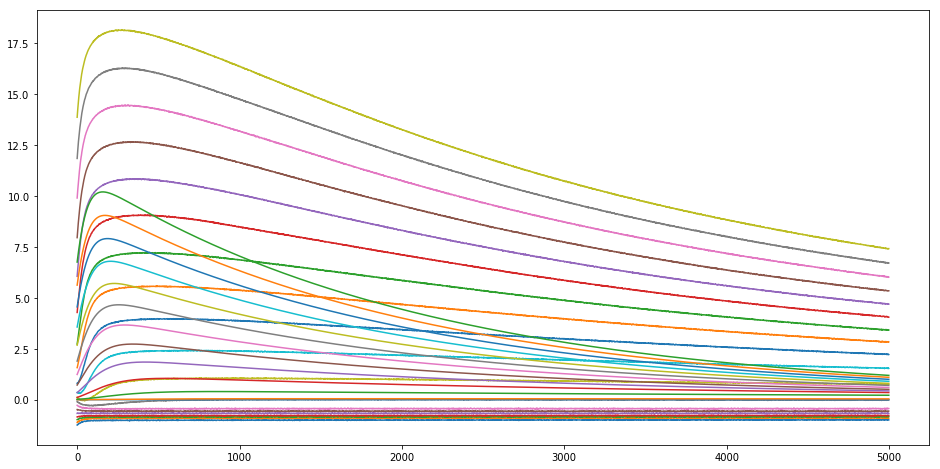

In [7]:
def HH(t, U, p):
    return p[0] * (1 - np.exp(-t/p[1]))**4 * (p[2] - (p[2]-1)*np.exp(-t/p[3])) * U

median_voltages = [np.median(V[Kv14.rec_limits[0]:Kv14.rec_limits[1]]) for V in ana[demo].rec.voltage]
t = np.arange(Kv14.rec_limits[1] - Kv14.rec_limits[0]) + Kv14.rec_limits[0] - Kv14.rec_step_t0

plt.figure(figsize=(16,8))
for I,V in zip(ana[5].rec.current, median_voltages):
    plt.plot(I[Kv14.rec_limits[0]:Kv14.rec_limits[0]+tplot] - ana[demo].params['I_leak'](V))
    
plt.gca().set_prop_cycle(None)

ret0 = None
#fits = []
for I,V in zip(ana[demo].rec.current[first_fitted:], median_voltages[first_fitted:]):
    U = V - ana[demo].params['E_K']
    p0 = [1.0e-1, 1.0e3, 1.0e-2, 1.0e3]
    ret1 = scipy.optimize.least_squares(lambda p, x, y: HH(x, U, p) - y,
                                        ret0.x,
                                        args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - ana[demo].params['I_leak'](V)),
                                        bounds = ([0.,0.,0.,0.], [np.inf, np.inf, 1., np.inf])
                                       ) if ret0 else None
    ret0 = scipy.optimize.least_squares(lambda p, x, y: HH(x, U, p) - y,
                                        p0,
                                        args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - ana[demo].params['I_leak'](V)),
                                        bounds = ([0.,0.,0.,0.], [np.inf, np.inf, 1., np.inf])
                                       )
    
    res = ret1.x if ret1 and ret1.cost < ret0.cost else ret0.x
    plt.plot(HH(t[:tplot], U, res))
    print res
    #fits.append((res, U))

[1.33282274e-11 1.06070065e+03 3.21152670e-04 1.05068544e+03]
[1.86653854e-03 2.87284591e+02 1.28825297e-01 1.51976787e+04]
[1.25747188e-02 1.98787304e+02 7.15292786e-02 5.72456839e+03]
[2.69171038e-02 1.43206088e+02 3.83396985e-02 3.59234080e+03]
[3.95939403e-02 1.14804954e+02 2.55327027e-02 2.84239291e+03]
[4.95960255e-02 9.74765528e+01 2.19763334e-02 2.52040008e+03]
[5.74748594e-02 8.55406687e+01 2.14343059e-02 2.36497924e+03]
[6.40621055e-02 7.68178175e+01 2.11478221e-02 2.27294144e+03]
[6.97655067e-02 7.00588567e+01 1.99866625e-02 2.21319902e+03]
[7.47779065e-02 6.47014390e+01 1.84792017e-02 2.17019954e+03]
[7.90745888e-02 6.02337712e+01 1.71816605e-02 2.13812949e+03]
[8.28259889e-02 5.64808429e+01 1.59472471e-02 2.11349021e+03]
[8.61311855e-02 5.32978700e+01 1.50813124e-02 2.08952660e+03]


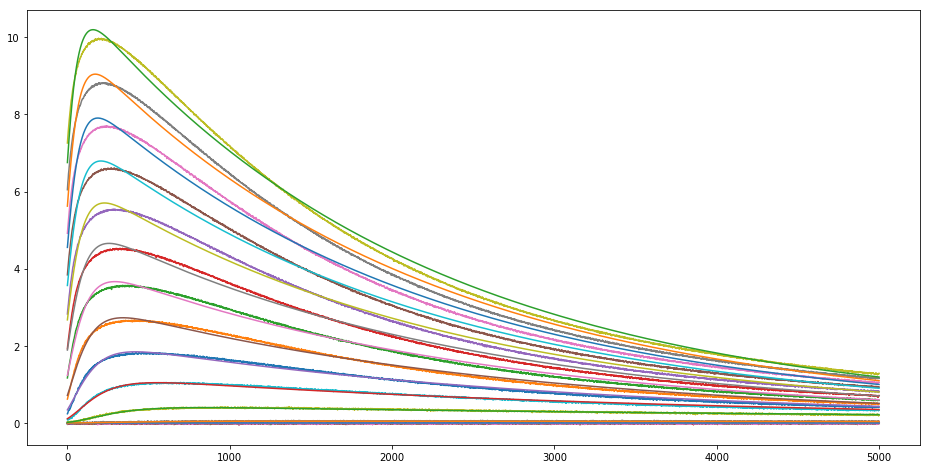

In [9]:
def HH(t, U, p):
    return p[0] * (1 - np.exp(-t/p[1]))**4 * (p[2] - (p[2]-1)*np.exp(-t/p[3])) * U

median_voltages = [np.median(V[Kv14.rec_limits[0]:Kv14.rec_limits[1]]) for V in ana[demo].rec.voltage]
t = np.arange(Kv14.rec_limits[1] - Kv14.rec_limits[0]) + Kv14.rec_limits[0] - Kv14.rec_step_t0

plt.figure(figsize=(16,8))
for I,V in zip(ana[demo].rec.current, median_voltages):
    plt.plot(I[Kv14.rec_limits[0]:Kv14.rec_limits[0]+tplot] - ana[demo].params['I_leak'](V))
    
plt.gca().set_prop_cycle(None)

ret0 = None
#fits = []
for I,V in zip(ana[demo].rec.current[first_fitted:], median_voltages[first_fitted:]):
    U = V - ana[demo].params['E_K']
    p0 = [1.0e-1, 1.0e3, 1.0e-2, 1.0e3]
    ret1 = ah.bounded_LM_fit(lambda p, x, y: HH(x, U, p) - y,
                                        ret0.x,
                                        args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - ana[demo].params['I_leak'](V)),
                                        bounds = ([0.,0.,0.,0.], [np.inf, np.inf, 1., np.inf])
                                       ) if ret0 else None
    ret0 = ah.bounded_LM_fit(lambda p, x, y: HH(x, U, p) - y,
                                        p0,
                                        args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - ana[demo].params['I_leak'](V)),
                                        bounds = ([0.,0.,0.,0.], [np.inf, np.inf, 1., np.inf])
                                       )
    
    res = ret1.x if ret1 and ret1.cost < ret0.cost else ret0.x
    plt.plot(HH(t[:tplot], U, res))
    print res
    #fits.append((res, U))

Neither of these fits look great, exactly... so let's try something else: Perhaps the model is too reductive. Could there be two components to it?
## Two components: One fast, one slow, both inactivating

In [8]:
# Some initial values from several iterations of trying to get a good fast & slow
fits_ext_p0 = [
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.42081465e-02, 3.80135749e+02, 6.38591759e-02, 4.87138978e+03, 4.53899075e-02, 9.91871948e+01, 1.04647195e-06, 1.46505568e+03],
    [1.73895186e-02, 2.84885303e+02, 6.61381567e-02, 4.68949830e+03, 5.17874316e-02, 7.48485617e+01, 1.45223442e-08, 1.44136454e+03],
    [1.73895186e-02, 2.74885303e+02, 6.41381567e-02, 4.69949830e+03, 5.57874316e-02, 7.08485617e+01, 1.45223442e-12, 1.44136454e+03],
    [1.73895186e-02, 2.64885303e+02, 6.21381567e-02, 4.70949830e+03, 6.17874316e-02, 6.68485617e+01, 1.45223442e-15, 1.44136454e+03],
    [1.73895186e-02, 2.54885303e+02, 6.01381567e-02, 4.72949830e+03, 6.57874316e-02, 6.28485617e+01, 1.45223442e-18, 1.44136454e+03],
    [1.73895186e-02, 2.44885303e+02, 5.81381567e-02, 4.74949830e+03, 7.17874316e-02, 5.88485617e+01, 1.45223442e-26, 1.44136454e+03],
    [1.75037140e-02, 2.29092127e+02, 5.51733567e-02, 4.78776232e+03, 7.55955872e-02, 5.43700416e+01, 5.21362349e-18, 1.44659691e+03],
    [1.72435134e-02, 2.13699825e+02, 5.23052040e-02, 4.88100112e+03, 7.89005902e-02, 5.06488733e+01, 2.67342944e-15, 1.46119205e+03],
    [1.66858504e-02, 1.97714913e+02, 5.16146762e-02, 4.98309796e+03, 8.17107281e-02, 4.74851633e+01, 9.26682489e-17, 1.48333106e+03]
]

[3.58007386e-08, 1.36280242e+04, 2.85290341e-15, 1.79943747e+02, 2.09828094e-03, 6.42148667e+03, 1.58011659e-13, 4.63888933e+01],  3.3757e+00
[4.08451776e-03, 2.21665616e+03, 6.40092321e-04, 5.12721040e+03, 1.37996634e-02, 6.68905391e+02, 3.61979991e-02, 7.86609685e+02],  1.7042e+00
[7.12847629e-03, 8.37464075e+02, 4.89414545e-05, 8.41064619e+03, 1.53369723e-02, 2.09737230e+02, 4.63588733e-02, 1.81656385e+03],  1.6110e+00
[6.39209771e-03, 4.71851458e+02, 2.15481803e-02, 9.24080157e+03, 2.73366191e-02, 1.40577557e+02, 1.66501052e-02, 2.19834980e+03],  1.6604e+00
[9.82736113e-03, 3.96455704e+02, 6.70141660e-02, 6.55879905e+03, 4.00527312e-02, 1.11644080e+02, 5.53947768e-05, 1.76738622e+03],  1.9916e+00
[1.24770552e-02, 3.37591674e+02, 6.24333447e-02, 5.44357542e+03, 4.90473153e-02, 9.27041371e+01, 4.68246367e-06, 1.59846120e+03],  2.3428e+00
[1.39256561e-02, 3.11137988e+02, 6.45259293e-02, 5.16761660e+03, 5.66602747e-02, 8.08791868e+01, 4.97280077e-05, 1.52637983e+03],  2.9244e+00
[1.554

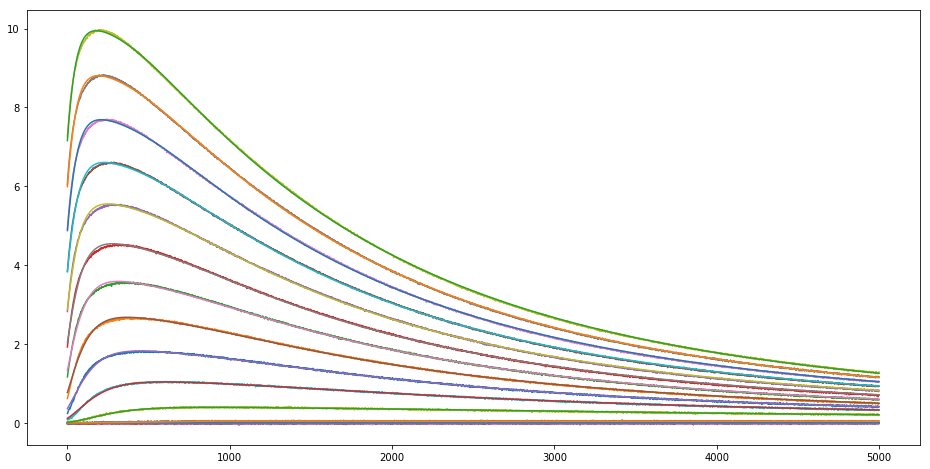

In [9]:
def HH_ext(t, U, p):
    return U * ( p[0] * (1 - np.exp(-t/p[1]))**4 * (p[2] - (p[2]-1)*np.exp(-t/p[3])) \
               + p[4] * (1 - np.exp(-t/p[5]))**4 * (p[6] - (p[6]-1)*np.exp(-t/p[7])) )

median_voltages = [np.median(V[Kv14.rec_limits[0]:Kv14.rec_limits[1]]) for V in ana[demo].rec.voltage]
t = np.arange(Kv14.rec_limits[1] - Kv14.rec_limits[0]) + Kv14.rec_limits[0] - Kv14.rec_step_t0

plt.figure(figsize=(16,8))
for I,V in zip(ana[demo].rec.current, median_voltages):
    plt.plot(I[Kv14.rec_limits[0]:Kv14.rec_limits[0]+tplot] - ana[demo].params['I_leak'](V))
plt.gca().set_prop_cycle(None)

ret0 = None
fits_ext = []
cost = 0
for I,V,p0 in zip(ana[demo].rec.current[first_fitted:], median_voltages[first_fitted:], fits_ext_p0):
    U = V - ana[demo].params['E_K']
    ret1 = scipy.optimize.least_squares(lambda p, x, y: HH_ext(x, U, p) - y,
                                        ret0.x,
                                        args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - ana[demo].params['I_leak'](V)),
                                        bounds = ([0.,0.,0.,0.,0.,0.,0.,0.],
                                                  [np.inf, np.inf, 1., np.inf, np.inf, np.inf, 1., np.inf])
                                       ) if ret0 else None
    ret0 = scipy.optimize.least_squares(lambda p, x, y: HH_ext(x, U, p) - y,
                                        p0,
                                        args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - ana[demo].params['I_leak'](V)),
                                        bounds = ([0.,0.,0.,0.,0.,0.,0.,0.],
                                                  [np.inf, np.inf, 1., np.inf, np.inf, np.inf, 1., np.inf])
                                       )
    
    ret = ret1 if ret1 and ret1.cost < ret0.cost else ret0
    plt.plot(HH_ext(t[:tplot], U, ret.x))
    print "[%.8e, %.8e, %.8e, %.8e, %.8e, %.8e, %.8e, %.8e],  %.4e" % tuple(ret.x.tolist() + [ret.cost])
    fits_ext.append((ret.x, U))
    cost += ret.cost
print cost

As in the Kv2.1 case, it seems to be possible to separate into two currents quite cleanly...

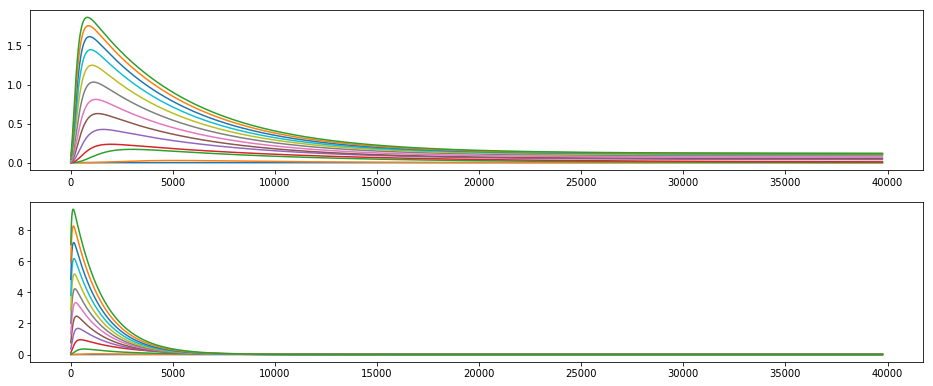

In [10]:
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
for p, U in fits_ext:
    plt.plot(U * (p[0] * (1 - np.exp(-t/p[1]))**4 * (p[2] - (p[2]-1)*np.exp(-t/p[3]))))
    
plt.subplot(3,1,2)
for p, U in fits_ext:
    plt.plot(U * (p[4] * (1 - np.exp(-t/p[5]))**4 * (p[6] - (p[6]-1)*np.exp(-t/p[7]))))

## Fitting all recordings
Single-component style first, to see if that's appropriate.

0 1182.6681624652147
1 583.5438525325945
2 119.14813732847061
3 730.3224884201737
4 686.2229691112994
5 1420.031005214293


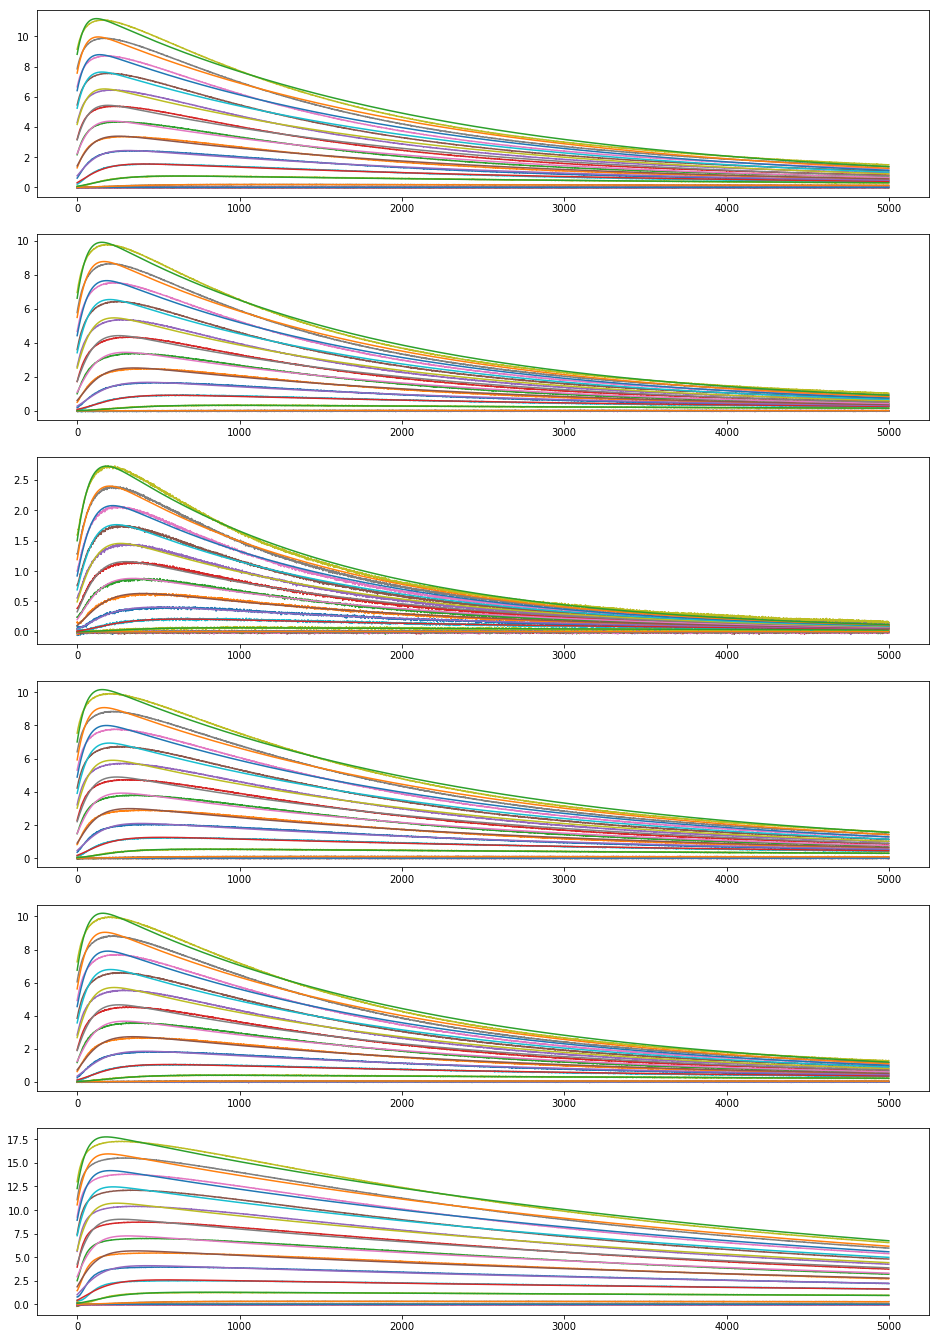

In [11]:
t = np.arange(Kv14.rec_limits[1] - Kv14.rec_limits[0]) + Kv14.rec_limits[0] - Kv14.rec_step_t0
plt.figure(figsize=(16,4*len(ana)))

p0_single = [
    [2.37123027e-03, 1.44579839e+02, 7.87454167e-01, 6.08021990e+03],
    [2.37123027e-03, 1.44579839e+02, 7.87454167e-01, 6.08021990e+03],
    [2.37123027e-03, 1.44579839e+02, 7.87454167e-01, 6.08021990e+03],
    [2.37123027e-03, 1.44579839e+02, 5.87454167e-01, 4.08021990e+03],
    [2.37123027e-03, 1.44579839e+02, 4.87454167e-01, 3.18021990e+03],
    [3.17565932e-03, 1.19447746e+02, 3.00403220e-01, 2.59535262e+03],
    [3.91143419e-03, 1.01973467e+02, 1.38772250e-01, 1.69963462e+03],
    [4.97275812e-03, 9.43900424e+01, 1.78080623e-01, 1.39477886e+03],
    [5.98527812e-03, 8.74002500e+01, 2.02008686e-01, 1.24104354e+03],
    [6.92851359e-03, 7.97630922e+01, 2.35234929e-01, 1.13504888e+03],
    [7.84329810e-03, 7.39463791e+01, 2.72798857e-01, 1.02342500e+03],
    [8.62886755e-03, 6.75487979e+01, 3.11013534e-01, 9.76700841e+02],
    [9.30694750e-03, 6.11089009e+01, 3.56630488e-01, 9.78822527e+02]
]

allfits = [None]*len(ana)

for i,a in enumerate(ana):
    median_voltages = [np.median(V[Kv14.rec_limits[0]:Kv14.rec_limits[1]]) for V in a.rec.voltage]

    plt.subplot(len(ana), 1, i + 1)
    for I,V in zip(a.rec.current, median_voltages):
        plt.plot(I[Kv14.rec_limits[0]:Kv14.rec_limits[0]+tplot] - a.params['I_leak'](V))
    plt.gca().set_prop_cycle(None)

    ret0 = None
    f = []
    cost = 0
    for I,V,p0 in zip(a.rec.current[first_fitted:], median_voltages[first_fitted:], p0_single):
        U = V - a.params['E_K']
        ret1 = scipy.optimize.least_squares(lambda p, x, y: HH(x, U, p) - y,
                                            ret0.x,
                                            args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - a.params['I_leak'](V)),
                                            bounds = ([0.,0.,0.,0.],
                                                      [np.inf, np.inf, 1., np.inf])
                                           ) if ret0 else None
        ret0 = scipy.optimize.least_squares(lambda p, x, y: HH(x, U, p) - y,
                                            p0,
                                            args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - a.params['I_leak'](V)),
                                            bounds = ([0.,0.,0.,0.],
                                                      [np.inf, np.inf, 1., np.inf])
                                           )

        ret = ret1 if ret1 and ret1.cost < ret0.cost else ret0
        plt.plot(HH(t[:tplot], U, ret.x))
#         print "[%.8e, %.8e, %.8e, %.8e, %.8e, %.8e],  %.4e" % tuple(ret.x.tolist() + [ret.cost])
        f.append((ret, U))
        cost += ret.cost
    
    print i, cost
    allfits[i] = f

I'd say there's only a single recording (third from the top) that fits reasonably well. Let's try to fit all with two components:

0 22.182320278593203
1 47.18171267370122
2 100.62002476820427
3 27.75738220286493
4 36.369143480932024
5 504.3564948165944


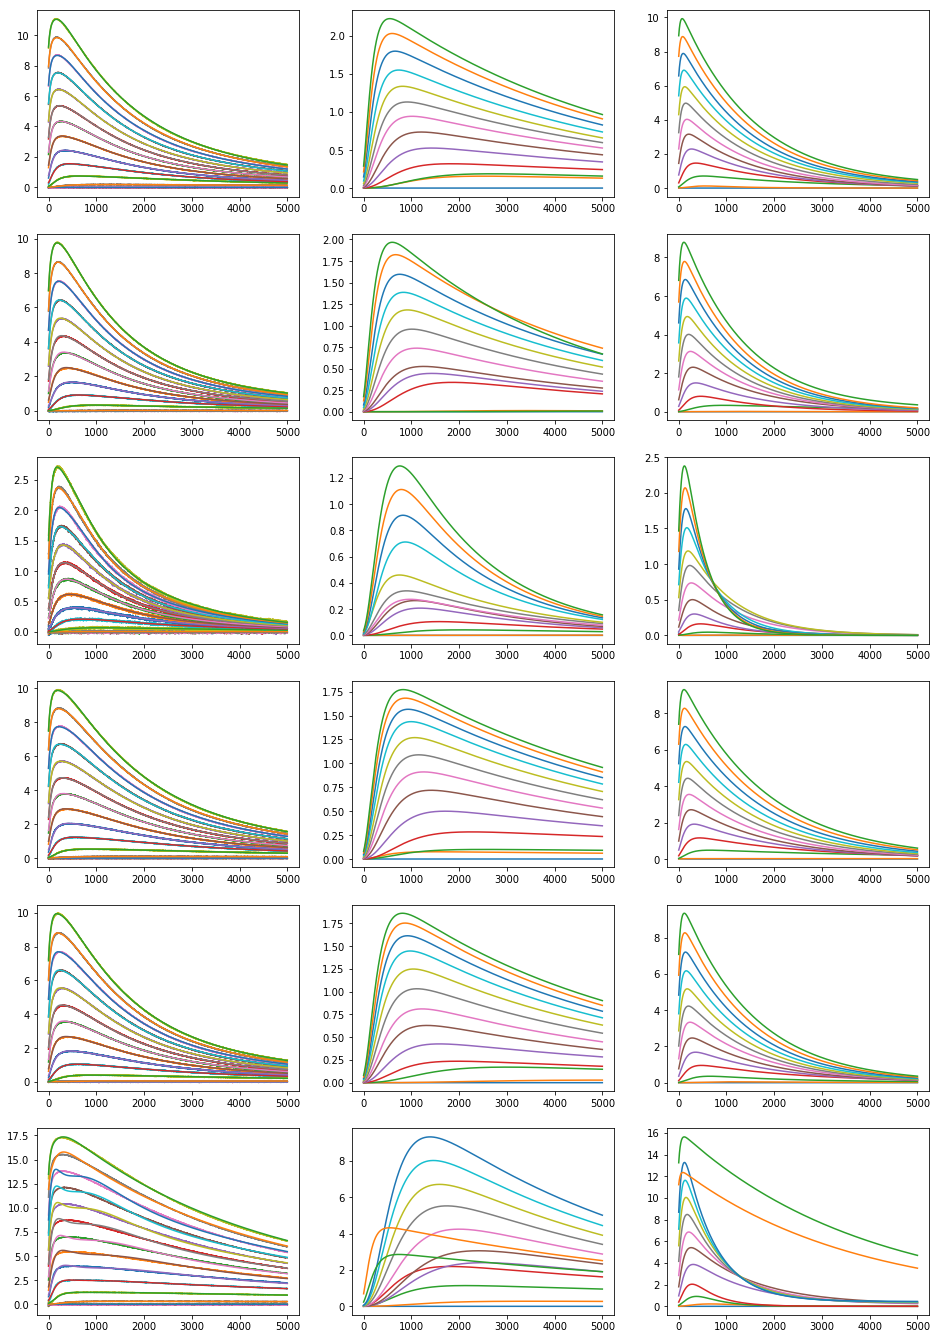

In [12]:
t = np.arange(Kv14.rec_limits[1] - Kv14.rec_limits[0]) + Kv14.rec_limits[0] - Kv14.rec_step_t0
plt.figure(figsize=(16,4*len(ana)))

allfits_ext = [None]*len(ana)

for i,a in enumerate(ana):
    median_voltages = [np.median(V[Kv14.rec_limits[0]:Kv14.rec_limits[1]]) for V in a.rec.voltage]

    plt.subplot(len(ana), 3, 3*i + 1)
    for I,V in zip(a.rec.current, median_voltages):
        plt.plot(I[Kv14.rec_limits[0]:Kv14.rec_limits[0]+tplot] - a.params['I_leak'](V))
    plt.gca().set_prop_cycle(None)

    ret0 = None
    f = []
    cost = 0
    for I,V,p0 in zip(a.rec.current[first_fitted:], median_voltages[first_fitted:], fits_ext_p0):
        U = V - a.params['E_K']
        ret1 = scipy.optimize.least_squares(lambda p, x, y: HH_ext(x, U, p) - y,
                                            ret0.x,
                                            args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - a.params['I_leak'](V)),
                                            bounds = ([0.,0.,0.,0.,0.,0.,0.,0.],
                                                      [np.inf, np.inf, 1., np.inf, np.inf, np.inf, 1., np.inf])
                                           ) if ret0 else None
        ret0 = scipy.optimize.least_squares(lambda p, x, y: HH_ext(x, U, p) - y,
                                            p0,
                                            args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - a.params['I_leak'](V)),
                                            bounds = ([0.,0.,0.,0.,0.,0.,0.,0.],
                                                      [np.inf, np.inf, 1., np.inf, np.inf, np.inf, 1., np.inf])
                                           )

        ret = ret1 if ret1 and ret1.cost < ret0.cost else ret0
        plt.plot(HH_ext(t[:tplot], U, ret.x))
#         print "[%.8e, %.8e, %.8e, %.8e, %.8e, %.8e],  %.4e" % tuple(ret.x.tolist() + [ret.cost])
        f.append((ret, U))
        cost += ret.cost
    
    print i, cost
    allfits_ext[i] = f
    
    plt.subplot(len(ana), 3, 3*i + 2)
    for p, U in f:
        plt.plot(U * (p.x[0] * (1 - np.exp(-t[:tplot]/p.x[1]))**4 * (p.x[2] - (p.x[2]-1)*np.exp(-t[:tplot]/p.x[3]))))

    plt.subplot(len(ana), 3, 3*i + 3)
    for p, U in f:
        plt.plot(U * (p.x[4] * (1 - np.exp(-t[:tplot]/p.x[5]))**4 * (p.x[6] - (p.x[6]-1)*np.exp(-t[:tplot]/p.x[7]))))

Very nice fits overall, but the split needs some attention. So, again: Individual fitting, go!

In [13]:
def fit_single(a, fit_p0, first = first_fitted, last = 19):
    t = np.arange(Kv14.rec_limits[1] - Kv14.rec_limits[0]) + Kv14.rec_limits[0] - Kv14.rec_step_t0
    plt.figure(figsize=(16,8))

    median_voltages = [np.median(V[Kv14.rec_limits[0]:Kv14.rec_limits[1]]) for V in a.rec.voltage]

    plt.subplot(1,3,1)
    for I,V in zip(a.rec.current, median_voltages):
        plt.plot(I[Kv14.rec_limits[0]:Kv14.rec_limits[0]+tplot] - a.params['I_leak'](V))
    plt.gca().set_prop_cycle(None)

    ret0 = None
    f = []
    cost = 0
    for I,V,p0 in zip(a.rec.current[first:last], median_voltages[first:last], fit_p0):
        U = V - a.params['E_K']
        ret1 = scipy.optimize.least_squares(lambda p, x, y: HH_ext(x, U, p) - y,
                                            ret0.x,
                                            args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - a.params['I_leak'](V)),
                                            bounds = ([0.,0.,0.,0.,0.,0.,0.,0.],
                                                      [np.inf, np.inf, 1., np.inf, np.inf, np.inf, 1., np.inf])
                                           ) if ret0 else None
        ret0 = scipy.optimize.least_squares(lambda p, x, y: HH_ext(x, U, p) - y,
                                            p0,
                                            args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - a.params['I_leak'](V)),
                                            bounds = ([0.,0.,0.,0.,0.,0.,0.,0.],
                                                      [np.inf, np.inf, 1., np.inf, np.inf, np.inf, 1., np.inf])
                                           )

        ret = ret1 if ret1 and ret1.cost < ret0.cost else ret0
        plt.plot(HH_ext(t[:tplot], U, ret.x))
        print "[%.4e, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e],  %.4e" % tuple(ret.x.tolist() + [ret.cost])
        f.append((ret, U))
        cost += ret.cost

    plt.subplot(1,3,2)
    for p, U in f:
        plt.plot(U * (p.x[0] * (1 - np.exp(-t[:tplot]/p.x[1]))**4 * (p.x[2] - (p.x[2]-1)*np.exp(-t[:tplot]/p.x[3]))))

    plt.subplot(1,3,3)
    for p, U in f:
        plt.plot(U * (p.x[4] * (1 - np.exp(-t[:tplot]/p.x[5]))**4 * (p.x[6] - (p.x[6]-1)*np.exp(-t[:tplot]/p.x[7]))))
        
    return f, cost

[5.0140e-08, 2.2719e+04, 1.8343e-20, 5.4145e+00, 3.3185e-06, 1.6742e+04, 2.1029e-14, 3.0771e-01],  2.7297e+00
[6.3885e-03, 8.8682e+02, 2.2475e-05, 1.0458e+04, 1.0923e-02, 2.5537e+02, 2.2039e-02, 1.2926e+03],  6.8473e-01
[6.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],  7.3823e-01
[8.0882e-03, 4.2823e+02, 4.3578e-02, 9.3862e+03, 3.9825e-02, 1.1221e+02, 3.1857e-29, 1.8764e+03],  9.6937e-01
[1.1238e-02, 3.4233e+02, 3.6673e-02, 7.1558e+03, 5.1287e-02, 8.8982e+01, 6.2501e-30, 1.5723e+03],  1.0901e+00
[1.3405e-02, 2.9197e+02, 3.5921e-02, 6.3191e+03, 5.8940e-02, 7.3694e+01, 1.3297e-05, 1.4757e+03],  1.0625e+00
[1.4652e-02, 2.4234e+02, 3.6695e-02, 6.0156e+03, 6.3806e-02, 6.2840e+01, 1.3951e-20, 1.4659e+03],  1.0468e+00
[1.5476e-02, 2.1777e+02, 2.2186e-02, 5.8269e+03, 6.8491e-02, 5.5700e+01, 3.4986e-03, 1.4670e+03],  1.0707e+00
[1.6330e-02, 1.9504e+02, 5.5298e-18, 5.6382e+03, 7.2223e-02, 5.0004e+01, 8.5453e-03, 1.4661e+03],  1.2928e+00
[1.7048e-0

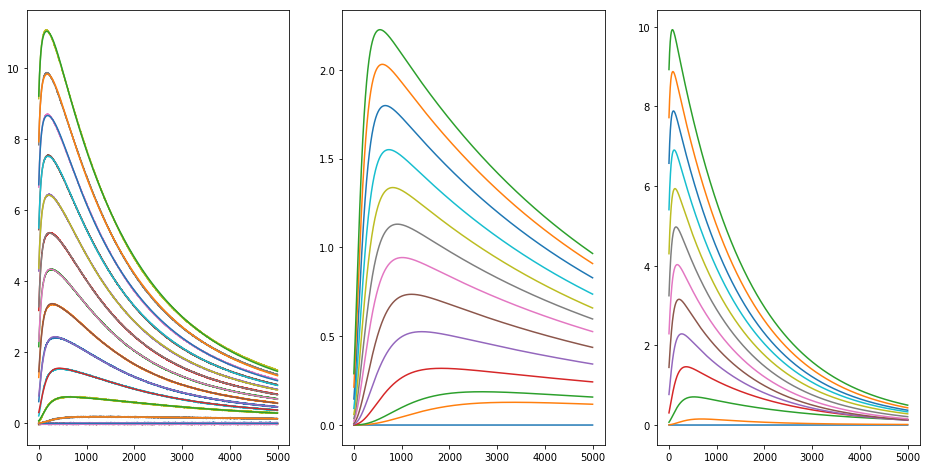

In [14]:
p0 = [
    [1.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [3.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.42081465e-02, 3.80135749e+02, 6.38591759e-02, 4.87138978e+03, 4.53899075e-02, 9.91871948e+01, 1.04647195e-06, 1.46505568e+03],
    [1.73895186e-02, 2.84885303e+02, 6.61381567e-02, 4.68949830e+03, 5.17874316e-02, 7.48485617e+01, 1.45223442e-08, 1.44136454e+03],
    [1.73895186e-02, 2.74885303e+02, 6.41381567e-02, 4.69949830e+03, 5.57874316e-02, 7.08485617e+01, 1.45223442e-12, 1.44136454e+03],
    [1.73895186e-02, 2.64885303e+02, 6.21381567e-02, 4.70949830e+03, 6.17874316e-02, 6.68485617e+01, 1.45223442e-15, 1.44136454e+03],
    [1.73895186e-02, 2.54885303e+02, 6.01381567e-02, 4.72949830e+03, 6.57874316e-02, 6.28485617e+01, 1.45223442e-18, 1.44136454e+03],
    [1.73895186e-02, 2.44885303e+02, 5.81381567e-02, 4.74949830e+03, 7.17874316e-02, 5.88485617e+01, 1.45223442e-26, 1.44136454e+03],
    [1.75037140e-02, 2.29092127e+02, 5.51733567e-02, 4.78776232e+03, 7.55955872e-02, 5.43700416e+01, 5.21362349e-18, 1.44659691e+03],
    [1.72435134e-02, 2.13699825e+02, 5.23052040e-02, 4.88100112e+03, 7.89005902e-02, 5.06488733e+01, 2.67342944e-15, 1.46119205e+03],
    [1.66858504e-02, 1.97714913e+02, 5.16146762e-02, 4.98309796e+03, 8.17107281e-02, 4.74851633e+01, 9.26682489e-17, 1.48333106e+03]
]
allfits_ext[0], cost = fit_single(ana[0], p0)
print cost

[1.1975e-10, 8.2894e+03, 1.7969e-19, 1.1182e-01, 3.4853e-10, 5.5481e+03, 2.4345e-15, 3.6206e-03],  1.7101e+01
[4.7806e+01, 2.3008e+04, 1.9908e-36, 9.5959e+02, 9.6660e+00, 6.0536e+03, 9.4592e-39, 3.9157e+02],  5.9017e+00
[1.0365e-02, 6.2291e+02, 3.3032e-30, 5.5105e+03, 1.8540e-02, 2.6019e+02, 1.1968e-28, 8.5979e+02],  2.3304e+00
[1.1851e-02, 5.3225e+02, 7.8961e-18, 5.2586e+03, 2.9475e-02, 1.6104e+02, 1.6504e-21, 1.3791e+03],  2.5155e+00
[1.1584e-02, 3.8767e+02, 5.7777e-36, 5.0765e+03, 4.0028e-02, 1.2135e+02, 3.2413e-38, 1.4517e+03],  2.4626e+00
[1.0975e-02, 3.2752e+02, 9.0338e-04, 5.2701e+03, 4.9614e-02, 1.0115e+02, 5.1801e-37, 1.4602e+03],  2.3443e+00
[1.3286e-02, 2.9030e+02, 1.5492e-02, 4.7407e+03, 5.6967e-02, 8.6150e+01, 3.6101e-36, 1.3691e+03],  2.6648e+00
[1.5067e-02, 2.6359e+02, 2.5029e-02, 4.4933e+03, 6.3075e-02, 7.5427e+01, 2.9505e-06, 1.3196e+03],  2.6779e+00
[1.6316e-02, 2.3672e+02, 3.1981e-02, 4.3615e+03, 6.7869e-02, 6.6955e+01, 1.1299e-05, 1.3016e+03],  2.4526e+00
[1.6960e-0

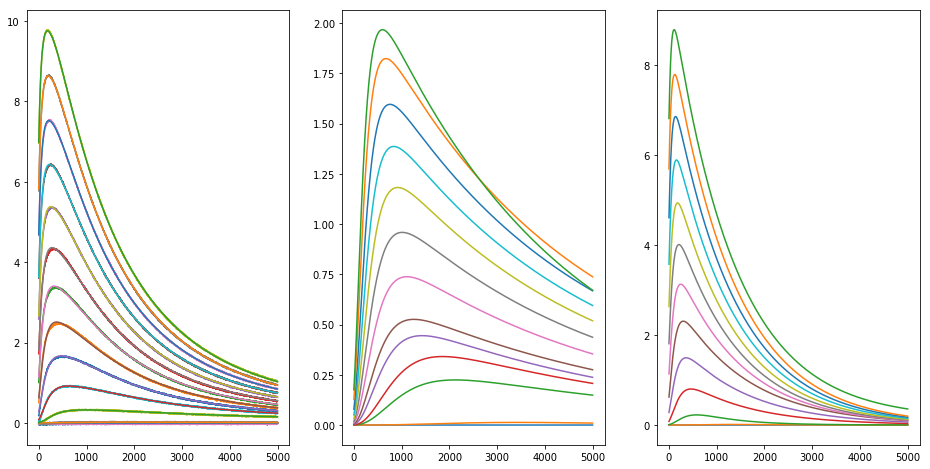

In [15]:
p0 = [
    [6.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [6.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [6.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.42081465e-02, 3.80135749e+02, 6.38591759e-02, 4.87138978e+03, 4.53899075e-02, 9.91871948e+01, 1.04647195e-06, 1.46505568e+03],
    [1.73895186e-02, 2.84885303e+02, 6.61381567e-02, 4.68949830e+03, 5.17874316e-02, 7.48485617e+01, 1.45223442e-08, 1.44136454e+03],
    [1.73895186e-02, 2.74885303e+02, 6.41381567e-02, 4.69949830e+03, 5.57874316e-02, 7.08485617e+01, 1.45223442e-12, 1.44136454e+03],
    [1.73895186e-02, 2.64885303e+02, 6.21381567e-02, 4.70949830e+03, 6.17874316e-02, 6.68485617e+01, 1.45223442e-15, 1.44136454e+03],
    [1.73895186e-02, 2.54885303e+02, 6.01381567e-02, 4.72949830e+03, 6.57874316e-02, 6.28485617e+01, 1.45223442e-18, 1.44136454e+03],
    [1.73895186e-02, 2.44885303e+02, 5.81381567e-02, 4.74949830e+03, 7.17874316e-02, 5.88485617e+01, 1.45223442e-26, 1.44136454e+03],
    [1.75037140e-02, 2.29092127e+02, 5.51733567e-02, 4.78776232e+03, 7.55955872e-02, 5.43700416e+01, 5.21362349e-18, 1.44659691e+03],
    [1.72435134e-02, 2.13699825e+02, 5.23052040e-02, 4.88100112e+03, 7.89005902e-02, 5.06488733e+01, 2.67342944e-15, 1.46119205e+03],
    [1.8035e-02, 1.6802e+02, 1.3165e-02, 1.3123e+03, 7.7004e-02, 5.0143e+01, 1.8661e-20, 3.9464e+03]
]
allfits_ext[1], cost = fit_single(ana[1], p0)
print cost

[1.3140e-08, 2.2719e+04, 1.0000e-10, 5.4145e+00, 8.3185e-07, 1.6742e+04, 1.0000e-10, 3.0771e-01],  1.4039e+00
[1.3275e-01, 1.3349e+04, 1.7784e-36, 1.5530e+03, 2.3300e-04, 4.0311e+02, 5.9613e-38, 2.5255e+03],  1.3678e+00
[1.5172e-03, 5.7639e+02, 5.8966e-25, 6.0456e+03, 2.2675e-03, 2.3670e+02, 6.5016e-22, 1.2157e+03],  1.3969e+00
[3.4884e-03, 4.8866e+02, 2.8761e-33, 3.7682e+03, 6.3598e-03, 1.8138e+02, 1.4448e-33, 1.0038e+03],  1.5298e+00
[6.0754e-03, 3.8414e+02, 3.7480e-33, 2.7050e+03, 9.7576e-03, 1.3848e+02, 1.8083e-34, 7.9355e+02],  2.2252e+00
[6.4910e-03, 3.4832e+02, 1.9069e-26, 2.6238e+03, 1.2445e-02, 1.1732e+02, 1.8896e-28, 8.5685e+02],  2.4687e+00
[5.2414e-03, 2.9136e+02, 2.1389e-35, 2.9617e+03, 1.4035e-02, 1.0108e+02, 7.8946e-38, 1.0261e+03],  2.4416e+00
[5.6516e-03, 2.6705e+02, 2.4003e-34, 2.8922e+03, 1.6191e-02, 9.0401e+01, 7.4641e-35, 1.0023e+03],  2.8515e+00
[6.7141e-03, 2.2262e+02, 3.6501e-36, 2.6369e+03, 1.7041e-02, 7.8630e+01, 4.6713e-35, 9.7096e+02],  4.4628e+00
[7.7288e-0

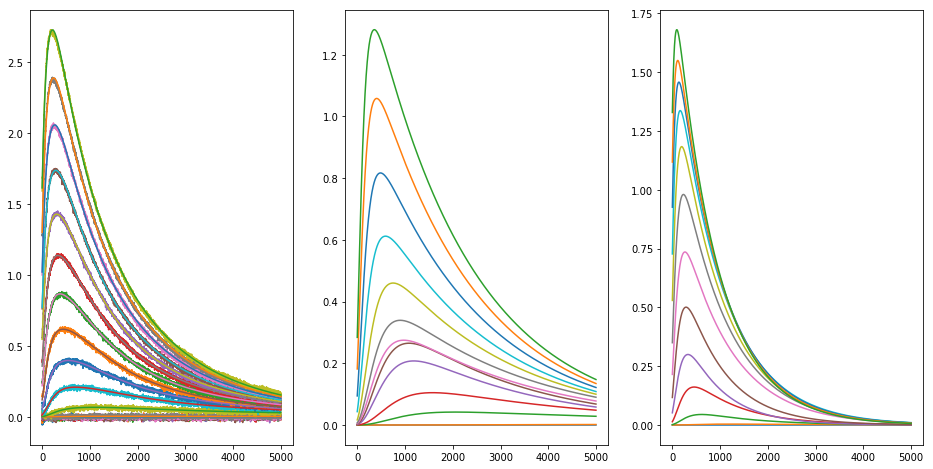

In [16]:
p0 = [
    [1.3140e-08, 2.2719e+04, 1.8343e-20, 5.4145e+00, 8.3185e-07, 1.6742e+04, 2.1029e-14, 3.0771e-01],
    [1.8885e-03, 8.8682e+02, 2.2475e-05, 1.0458e+04, 2.4923e-03, 2.5537e+02, 2.2039e-02, 1.2926e+03],
    [2.2786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 6.0308e-03, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [2.0882e-03, 4.2823e+02, 4.3578e-02, 9.3862e+03, 1.0825e-02, 1.1221e+02, 3.1857e-29, 1.8764e+03],
    [4.9414e-03, 3.6136e+02, 2.1389e-35, 3.9617e+03, 1.0035e-02, 3.0108e+02, 7.8946e-38, 1.0261e+03],
    [5.0414e-03, 3.2136e+02, 2.1389e-35, 3.2617e+03, 1.2035e-02, 2.0108e+02, 7.8946e-38, 1.0261e+03],
    [3.5652e-03, 2.4234e+02, 3.6695e-02, 6.0156e+03, 1.7806e-02, 6.2840e+01, 1.3951e-20, 1.4659e+03],
    [3.8476e-03, 2.1777e+02, 2.2186e-02, 5.8269e+03, 1.8491e-02, 5.5700e+01, 3.4986e-03, 1.4670e+03],
    [4.0330e-03, 1.9504e+02, 5.5298e-18, 5.6382e+03, 2.0223e-02, 5.0004e+01, 8.5453e-03, 1.4661e+03],
    [4.3048e-03, 1.7489e+02, 1.3271e-17, 5.5011e+03, 2.1416e-02, 4.5468e+01, 8.5272e-03, 1.4818e+03],
    [4.4947e-03, 1.5633e+02, 5.7562e-19, 5.4025e+03, 2.2217e-02, 4.1540e+01, 8.2158e-03, 1.4855e+03],
    [4.5359e-03, 1.4154e+02, 5.3694e-19, 5.3021e+03, 2.3634e-02, 3.8512e+01, 7.9238e-03, 1.5139e+03],
    [4.5535e-03, 1.2990e+02, 8.9734e-18, 5.1781e+03, 2.1876e-02, 3.5929e+01, 8.1433e-03, 1.5339e+03]
]
allfits_ext[2], cost = fit_single(ana[2], p0)
print cost

In [17]:
#### For 2017_12_06_{65-69}, which just doesn't fucking want to fit into the mould....
#### even when given a very, VERY close hand-fitted approximation.
#### Discarding it because it's a low-expression outlier anyway.
# p0 = [
#     [3.3e-3, 1e2, 3.3e-1, 1.4e3,
#       6.6e-3, 4e1, 3.3e-1, 0.7e3]
# ]
# allfits[3], cost = fit_single(ana[3], p0, 18)
# print cost


# p0 = [3.3e-3, 1e2, 3.3e-1, 1.4e3,
#       6.6e-3, 4e1, 3.3e-1, 0.7e3]

# plt.subplot(1,3,1)
# plt.plot(HH_ext(t[:tplot], U, p0))

# plt.subplot(1,3,2)
# plt.plot(allfits[3][-1][1] * (p0[0] * (1 - np.exp(-t[:tplot]/p0[1]))**4 * (p0[2] - (p0[2]-1)*np.exp(-t[:tplot]/p0[3]))))

# plt.subplot(1,3,3)
# plt.plot(allfits[3][-1][1] * (p0[4] * (1 - np.exp(-t[:tplot]/p0[5]))**4 * (p0[6] - (p0[6]-1)*np.exp(-t[:tplot]/p0[7]))))

[1.6788e-11, 2.2749e+04, 3.3687e-06, 4.3766e+00, 2.6839e-04, 5.3207e+03, 4.3057e-01, 3.0771e-01],  1.4009e+00
[3.2325e-03, 3.6206e+02, 3.0560e-05, 1.4328e+04, 5.0490e-03, 1.9937e+02, 1.7249e-01, 3.4233e+02],  1.3821e+00
[3.2804e-03, 5.0455e+02, 9.6220e-05, 1.8804e+04, 1.6036e-02, 1.5890e+02, 4.8183e-02, 4.3338e+03],  1.4457e+00
[7.8238e-03, 5.2998e+02, 1.1513e-01, 9.9598e+03, 3.2767e-02, 1.2578e+02, 1.0330e-12, 2.4364e+03],  1.5958e+00
[1.2074e-02, 4.2368e+02, 7.9312e-02, 6.7620e+03, 4.4773e-02, 1.0066e+02, 8.9493e-06, 1.8930e+03],  1.9672e+00
[1.4480e-02, 3.5531e+02, 7.0417e-02, 5.8641e+03, 5.2802e-02, 8.3948e+01, 5.8161e-31, 1.7272e+03],  2.0692e+00
[1.5665e-02, 3.1286e+02, 6.9868e-02, 5.6056e+03, 5.8874e-02, 7.2913e+01, 7.2113e-19, 1.6726e+03],  2.1378e+00
[1.6274e-02, 2.8387e+02, 6.9228e-02, 5.5580e+03, 6.3765e-02, 6.4843e+01, 2.7622e-20, 1.6590e+03],  2.2017e+00
[1.6741e-02, 2.6124e+02, 6.5897e-02, 5.5365e+03, 6.7821e-02, 5.8671e+01, 9.7672e-18, 1.6573e+03],  2.2479e+00
[1.6895e-0

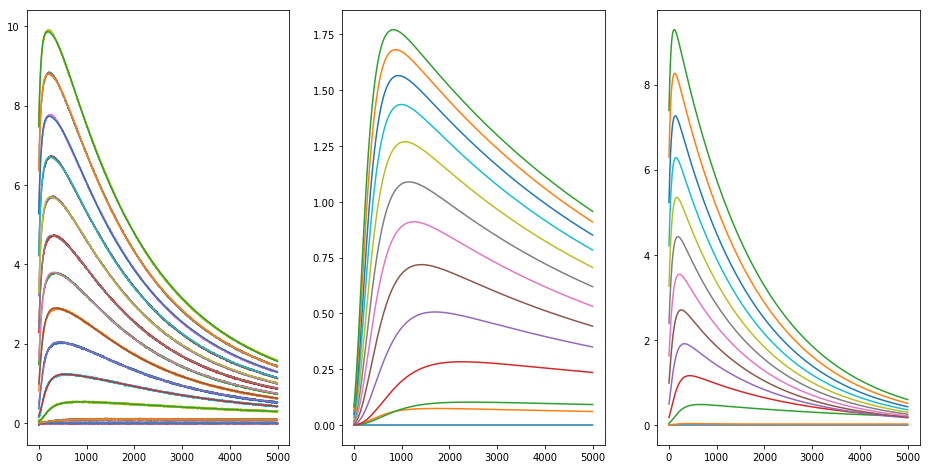

In [18]:
p0 = [
    [1.3140e-08, 2.2719e+04, 1.8343e-20, 5.4145e+00, 8.3185e-07, 1.6742e+04, 2.1029e-14, 3.0771e-01],
    [1.8885e-03, 8.8682e+02, 2.2475e-05, 1.0458e+04, 2.4923e-03, 2.5537e+02, 2.2039e-02, 1.2926e+03],
    [6.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [2.0882e-03, 4.2823e+02, 4.3578e-02, 9.3862e+03, 1.0825e-02, 1.1221e+02, 3.1857e-29, 1.8764e+03],
    [4.9414e-03, 3.6136e+02, 2.1389e-35, 3.9617e+03, 1.0035e-02, 3.0108e+02, 7.8946e-38, 1.0261e+03],
    [5.0414e-03, 3.2136e+02, 2.1389e-35, 3.2617e+03, 1.2035e-02, 2.0108e+02, 7.8946e-38, 1.0261e+03],
    [3.5652e-03, 2.4234e+02, 3.6695e-02, 6.0156e+03, 1.7806e-02, 6.2840e+01, 1.3951e-20, 1.4659e+03],
    [3.8476e-03, 2.1777e+02, 2.2186e-02, 5.8269e+03, 1.8491e-02, 5.5700e+01, 3.4986e-03, 1.4670e+03],
    [4.0330e-03, 1.9504e+02, 5.5298e-18, 5.6382e+03, 2.0223e-02, 5.0004e+01, 8.5453e-03, 1.4661e+03],
    [4.3048e-03, 1.7489e+02, 1.3271e-17, 5.5011e+03, 2.1416e-02, 4.5468e+01, 8.5272e-03, 1.4818e+03],
    [4.4947e-03, 1.5633e+02, 5.7562e-19, 5.4025e+03, 2.2217e-02, 4.1540e+01, 8.2158e-03, 1.4855e+03],
    [4.5359e-03, 1.4154e+02, 5.3694e-19, 5.3021e+03, 2.3634e-02, 3.8512e+01, 7.9238e-03, 1.5139e+03],
    [4.5535e-03, 1.2990e+02, 8.9734e-18, 5.1781e+03, 2.1876e-02, 3.5929e+01, 8.1433e-03, 1.5339e+03]
]
allfits_ext[3], cost = fit_single(ana[3], p0)
print cost

[6.4318e-12, 1.6949e+04, 4.9518e-21, 1.1310e-01, 4.7327e-10, 9.6033e+03, 6.0898e-16, 1.5069e-03],  3.3757e+00
[1.6382e-03, 3.5380e+02, 3.7524e-05, 1.4714e+04, 1.0649e-03, 1.5825e+02, 2.3751e-01, 3.2819e+02],  1.5582e+00
[7.1285e-03, 8.3746e+02, 4.8941e-05, 8.4106e+03, 1.5337e-02, 2.0974e+02, 4.6359e-02, 1.8166e+03],  1.6110e+00
[6.3921e-03, 4.7185e+02, 2.1548e-02, 9.2408e+03, 2.7337e-02, 1.4058e+02, 1.6650e-02, 2.1983e+03],  1.6604e+00
[9.8274e-03, 3.9646e+02, 6.7014e-02, 6.5588e+03, 4.0053e-02, 1.1164e+02, 5.5395e-05, 1.7674e+03],  1.9916e+00
[1.2477e-02, 3.3759e+02, 6.2433e-02, 5.4436e+03, 4.9047e-02, 9.2704e+01, 4.6825e-06, 1.5985e+03],  2.3428e+00
[1.3926e-02, 3.1114e+02, 6.4526e-02, 5.1676e+03, 5.6660e-02, 8.0879e+01, 4.9728e-05, 1.5264e+03],  2.9244e+00
[1.5547e-02, 2.8313e+02, 6.5108e-02, 4.9352e+03, 6.2430e-02, 7.1548e+01, 5.3426e-36, 1.4752e+03],  3.4524e+00
[1.6731e-02, 2.6295e+02, 6.2080e-02, 4.8009e+03, 6.7451e-02, 6.4446e+01, 5.1356e-34, 1.4484e+03],  3.6018e+00
[1.7390e-0

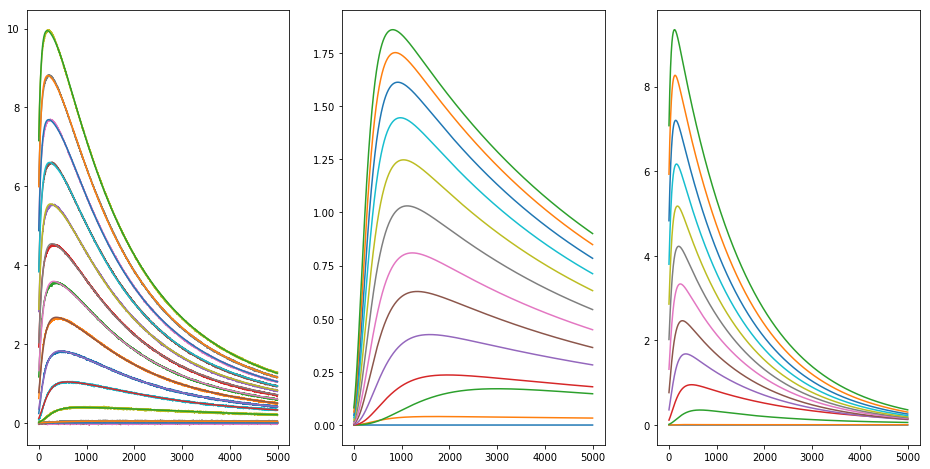

In [19]:
p0 = [
    [1.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [3.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.42081465e-02, 3.80135749e+02, 6.38591759e-02, 4.87138978e+03, 4.53899075e-02, 9.91871948e+01, 1.04647195e-06, 1.46505568e+03],
    [1.73895186e-02, 2.84885303e+02, 6.61381567e-02, 4.68949830e+03, 5.17874316e-02, 7.48485617e+01, 1.45223442e-08, 1.44136454e+03],
    [1.73895186e-02, 2.74885303e+02, 6.41381567e-02, 4.69949830e+03, 5.57874316e-02, 7.08485617e+01, 1.45223442e-12, 1.44136454e+03],
    [1.73895186e-02, 2.64885303e+02, 6.21381567e-02, 4.70949830e+03, 6.17874316e-02, 6.68485617e+01, 1.45223442e-15, 1.44136454e+03],
    [1.73895186e-02, 2.54885303e+02, 6.01381567e-02, 4.72949830e+03, 6.57874316e-02, 6.28485617e+01, 1.45223442e-18, 1.44136454e+03],
    [1.73895186e-02, 2.44885303e+02, 5.81381567e-02, 4.74949830e+03, 7.17874316e-02, 5.88485617e+01, 1.45223442e-26, 1.44136454e+03],
    [1.75037140e-02, 2.29092127e+02, 5.51733567e-02, 4.78776232e+03, 7.55955872e-02, 5.43700416e+01, 5.21362349e-18, 1.44659691e+03],
    [1.72435134e-02, 2.13699825e+02, 5.23052040e-02, 4.88100112e+03, 7.89005902e-02, 5.06488733e+01, 2.67342944e-15, 1.46119205e+03],
    [1.66858504e-02, 1.97714913e+02, 5.16146762e-02, 4.98309796e+03, 8.17107281e-02, 4.74851633e+01, 9.26682489e-17, 1.48333106e+03]
]
allfits_ext[4], cost = fit_single(ana[4], p0)
print cost

[8.2409e-12, 1.0316e+04, 5.1351e-15, 4.3999e+00, 1.6727e-09, 7.4316e+03, 2.9678e-11, 9.4349e-02],  4.7093e+01
[7.4646e-04, 3.2347e+03, 1.0781e-02, 3.7148e+04, 1.3307e-02, 2.4566e+02, 1.0552e-01, 1.8460e+04],  1.4643e+00
[2.4385e-03, 8.6892e+02, 1.4340e-04, 3.7488e+04, 3.8277e-02, 1.4616e+02, 7.7392e-02, 1.0809e+04],  2.1106e+00
[7.1549e-03, 5.3460e+02, 1.4250e-29, 3.7279e+04, 5.9033e-02, 1.0678e+02, 3.2416e-02, 7.1504e+03],  7.5295e+00
[1.3118e-02, 3.6375e+02, 1.0026e-24, 2.7449e+04, 7.4170e-02, 8.5054e+01, 1.1205e-24, 5.5237e+03],  1.3488e+01
[1.4801e-02, 3.8825e+02, 1.4869e-07, 2.2113e+04, 8.8986e-02, 7.4617e+01, 1.6922e-03, 4.7776e+03],  1.3605e+01
[1.5432e-02, 3.2487e+02, 7.1257e-16, 1.9455e+04, 9.9059e-02, 6.5891e+01, 6.2872e-03, 4.4583e+03],  1.3036e+01
[1.6619e-02, 2.6776e+02, 4.2437e-06, 1.5463e+04, 1.0708e-01, 5.8594e+01, 1.6087e-02, 4.2098e+03],  1.3909e+01
[1.9675e-02, 2.2320e+02, 3.5032e-16, 1.3275e+04, 1.1139e-01, 5.1933e+01, 1.9415e-02, 3.9816e+03],  1.7000e+01
[2.2209e-0

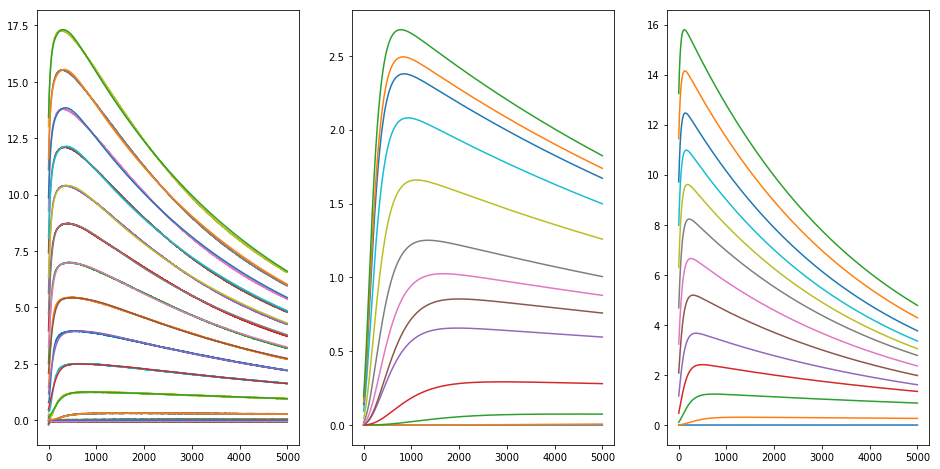

In [20]:
p0 = [
    [2.4385e-03, 8.6892e+02, 1.4340e-04, 3.7488e+04, 3.8277e-02, 1.4616e+02, 7.7392e-02, 1.0809e+04],
    [2.4385e-03, 8.6892e+02, 1.4340e-04, 3.7488e+04, 3.8277e-02, 1.4616e+02, 7.7392e-02, 1.0809e+04],
    [7.1551e-03, 5.3459e+02, 5.1215e-23, 3.7265e+04, 5.9033e-02, 1.0678e+02, 3.2432e-02, 7.1503e+03],
    [1.3096e-02, 5.2826e+02, 8.3278e-04, 2.4369e+04, 7.6914e-02, 8.7307e+01, 8.8415e-03, 5.3261e+03],
    [1.7077e-02, 2.6218e+02, 7.7466e-04, 1.5035e+04, 1.0674e-01, 5.8387e+01, 1.6584e-02, 4.1912e+03],
    [1.7077e-02, 2.6218e+02, 7.7466e-04, 1.5035e+04, 1.0674e-01, 5.8387e+01, 1.6584e-02, 4.1912e+03],
    [1.7077e-02, 2.6218e+02, 7.7466e-04, 1.5035e+04, 1.0674e-01, 5.8387e+01, 1.6584e-02, 4.1912e+03],
    [3.8476e-03, 2.1777e+02, 2.2186e-02, 5.8269e+03, 1.8491e-02, 5.5700e+01, 3.4986e-03, 1.4670e+03],
    [4.0330e-03, 1.9504e+02, 5.5298e-18, 5.6382e+03, 2.0223e-02, 5.0004e+01, 8.5453e-03, 1.4661e+03],
    [4.3048e-03, 1.7489e+02, 1.3271e-17, 5.5011e+03, 2.1416e-02, 4.5468e+01, 8.5272e-03, 1.4818e+03],
    [4.4947e-03, 1.5633e+02, 5.7562e-19, 5.4025e+03, 2.2217e-02, 4.1540e+01, 8.2158e-03, 1.4855e+03],
    [4.5359e-03, 1.4154e+02, 5.3694e-19, 5.3021e+03, 2.3634e-02, 3.8512e+01, 7.9238e-03, 1.5139e+03],
    [4.5535e-03, 1.2990e+02, 8.9734e-18, 5.1781e+03, 2.1876e-02, 3.5929e+01, 8.1433e-03, 1.5339e+03]
]
allfits_ext[5], cost = fit_single(ana[5], p0)
print cost

Let's have a look at the voltage dependency of these params:

/usr/lib64/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


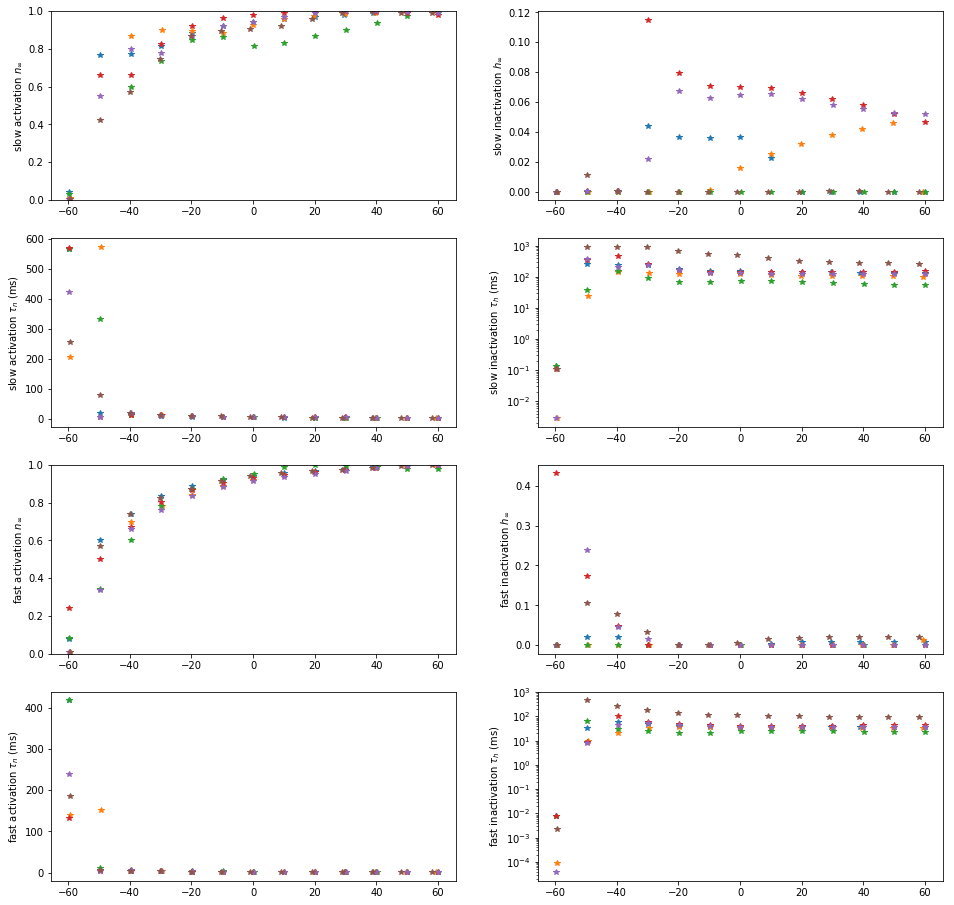

In [21]:
plt.figure(figsize=(16,16))

plt.subplot(4,2,1).set_ylabel(r'slow activation $n_\infty$')
plt.subplot(4,2,2).set_ylabel(r'slow inactivation $h_\infty$')
plt.subplot(4,2,3).set_ylabel(r'slow activation $\tau_n$ (ms)')
plt.subplot(4,2,4).set_ylabel(r'slow inactivation $\tau_h$ (ms)')

plt.subplot(4,2,5).set_ylabel(r'fast activation $n_\infty$')
plt.subplot(4,2,6).set_ylabel(r'fast inactivation $h_\infty$')
plt.subplot(4,2,7).set_ylabel(r'fast activation $\tau_n$ (ms)')
plt.subplot(4,2,8).set_ylabel(r'fast inactivation $\tau_h$ (ms)')

V = []
ns, hs, tns, ths = [],[],[],[]
nf, hf, tnf, thf = [],[],[],[]

for i, a in enumerate(ana):    
    ret, V_ = zip(*allfits_ext[i])
    params = [r.x for r in ret]
    V_ += a.params['E_K']
    V.extend(V_)
    
    # slow activation
    plt.subplot(4, 2, 1)
    p = [el[0] for el in params]
    a.params['gA_slow'] = max(p[-7:])
    n_ = [(el / a.params['gA_slow'])**0.25 for el in p]
    ns.extend(n_)
    plt.plot(V_, n_, '*')
    plt.ylim(0,1)
    
    # slow inactivation
    plt.subplot(4,2,2)
    h_ = [el[2] for el in params]
    hs.extend(h_)
    plt.plot(V_, h_, '*')
    
    # slow activation tau
    plt.subplot(4,2,3)
#     tn_ = [(el[1] if el[1] < 2500 else 2600) * Kv21.tres for el in params]
    tn_ = [el[1] * Kv14.tres for el in params]
    tns.extend(tn_)
    plt.plot(V_, tn_, '*')
    
    # slow inactivation tau
    plt.subplot(4,2,4)
    th_ = [el[3] * Kv14.tres for el in params]
    ths.extend(th_)
    plt.semilogy(V_, th_, '*')
    
    # fast activation
    plt.subplot(4, 2, 5)
    p = [el[4] for el in params]
    a.params['gA_fast'] = max(p[-7:])
    n_ = [(el / a.params['gA_fast'])**0.25 for el in p]
    nf.extend(n_)
    plt.plot(V_, n_, '*')
    plt.ylim(0,1)
    
    # fast inactivation
    plt.subplot(4,2,6)
    h_ = [el[6] for el in params]
    hf.extend(h_)
    plt.plot(V_, h_, '*')
    
    # fast activation tau
    plt.subplot(4,2,7)
#     tn_ = [(el[1] if el[1] < 2500 else 2600) * Kv21.tres for el in params]
    tn_ = [el[5] * Kv14.tres for el in params]
    tnf.extend(tn_)
    plt.plot(V_, tn_, '*')
    
    # fast inactivation tau
    plt.subplot(4,2,8)
    th_ = [el[7] * Kv14.tres for el in params]
    thf.extend(th_)
    plt.semilogy(V_, th_, '*')

In [22]:
for a in ana:
    print '%s:\n%s\n' % (a.paramsfile, a.params_str())
    a.write()

/home/kernfel/Documents/Data/Oocytes/2017_12_06_0039.params:
gl:	2.526743 μS
El:	-28.738655 mV
gA:	83.230559 μS
EK:	-80.001965 mV
C:	176.326881 nF
gA_fast:	81.876076 μS
gA_slow:	18.535426 μS


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0059.params:
gl:	9.924003 μS
El:	-14.031340 mV
gA:	75.895646 μS
EK:	-75.920659 mV
C:	183.766556 nF
gA_fast:	79.338654 μS
gA_slow:	18.093808 μS


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0064.params:
gl:	1.749784 μS
El:	-31.197546 mV
gA:	19.988201 μS
EK:	-83.274804 mV
C:	211.055611 nF
gA_fast:	17.040910 μS
gA_slow:	11.781791 μS


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0074.params:
gl:	1.205766 μS
El:	-18.762992 mV
gA:	76.309452 μS
EK:	-76.495133 mV
C:	188.968863 nF
gA_fast:	79.193030 μS
gA_slow:	16.895008 μS


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0079.params:
gl:	2.149622 μS
El:	-14.324841 mV
gA:	75.935608 μS
EK:	-77.991601 mV
C:	202.428834 nF
gA_fast:	81.710736 μS
gA_slow:	17.503690 μS


/home/kernfel/Documents/Data/Oocyte

The number of viable recordings being very small, hand-tuned parameters will likely yield better results. Note, $n_\infty$ and $h_\infty$ seem to behave very similarly between the two components, and are therefore modelled with largely the same parameters.

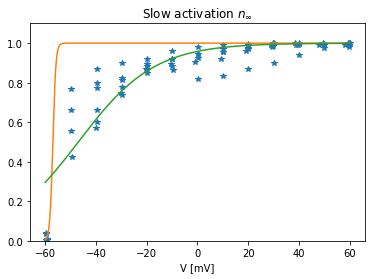

In [23]:
def sigmoid(p, v):
    return 1/(1+np.exp((p[0]-v)/p[1]))
Vprobe = np.arange(-60,60,0.1)
fit_ns = scipy.optimize.least_squares(lambda p, x, y: sigmoid(p,x) - y, [10, 10], args = (V, ns))
plt.plot(V, ns, '*')
plt.plot(Vprobe, sigmoid(fit_ns.x, Vprobe))
plt.title(r'Slow activation $n_\infty$')
plt.xlabel('V [mV]')
plt.ylim(0,1.1)

ns_p0 = [-47, 15]
plt.plot(Vprobe, sigmoid(ns_p0, Vprobe));

V_half =  -219.49374421525758
V_slope =  -1.377220509678465
noninact =  0.020951717390792057


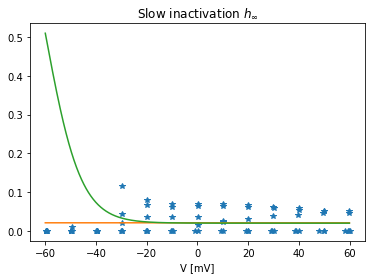

In [24]:
def sigmoid_min(p, v):
    return p[2] + (1-p[2])/(1+np.exp((p[0]-v)/p[1]))
fit_hs = scipy.optimize.least_squares(lambda p, x, y: sigmoid_min(p,x) - y, [-48., -5., .02], args = (V, hs))
plt.plot(V, hs, '*')
plt.plot(Vprobe, sigmoid_min(fit_hs.x, Vprobe))
plt.title(r'Slow inactivation $h_\infty$')
plt.xlabel('V [mV]')
print 'V_half = ', fit_hs.x[0]
print 'V_slope = ', fit_hs.x[1]
print 'noninact = ', fit_hs.x[2]

hs_p0 = [-60.,-7.,.02]
plt.plot(Vprobe, sigmoid_min(hs_p0, Vprobe));

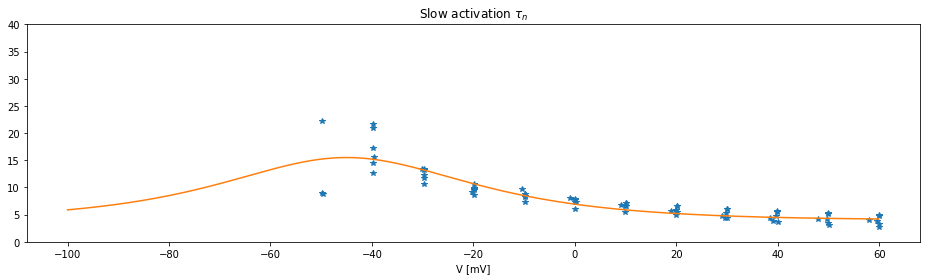

In [25]:
tauns_p0 = [4, 23., 45., 22., -22.]
def tau_model(p, V):
#   tau_min + tau_max/(np.exp((tau_off+V)/tau_slope1) + np.exp((tau_off+V)/tau_slope2))
    return p[0] + p[1]/(np.exp((p[2]+V)/p[3]) + np.exp((p[2]+V)/p[4]))

Vprobe = np.arange(-100,60,0.1)

plt.figure(figsize=(16,4))
plt.plot(V, tns, '*')
plt.plot(Vprobe, tau_model(tauns_p0, Vprobe))

plt.title(r'Slow activation $\tau_n$')
plt.ylim(0,40)
plt.xlabel('V [mV]');

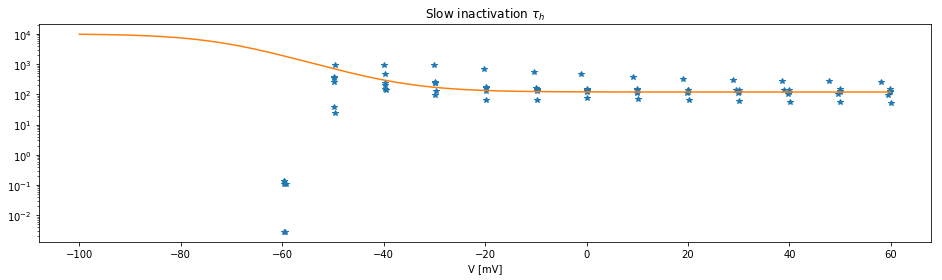

In [26]:
tauhs_p0 = [120., 1e4, 72., 8.]
def taui_model(p, V):
#     $(tauhK_min) + $(tauhK_max)/(1.0 + exp(($(tauhK_mid)-$(V))/$(tauhK_slope)))
    return p[0] + p[1]/(1. + np.exp((p[2]+V)/p[3]))

plt.figure(figsize=(16,4))
plt.semilogy(V, ths, '*')
plt.semilogy(Vprobe, taui_model(tauhs_p0, Vprobe))

plt.title(r'Slow inactivation $\tau_h$')
# plt.ylim(3e1, 2e4)
plt.xlabel('V [mV]');

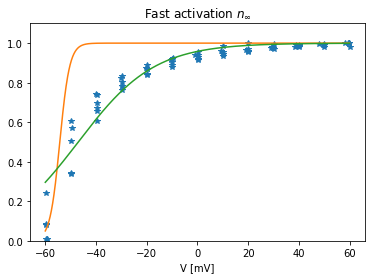

In [27]:
def sigmoid(p, v):
    return 1/(1+np.exp((p[0]-v)/p[1]))
Vprobe = np.arange(-60,60,0.1)
fit_nf = scipy.optimize.least_squares(lambda p, x, y: sigmoid(p,x) - y, [10, 10], args = (V, nf))
plt.plot(V, nf, '*')
plt.plot(Vprobe, sigmoid(fit_nf.x, Vprobe))
plt.title(r'Fast activation $n_\infty$')
plt.xlabel('V [mV]')
plt.ylim(0,1.1)

nf_p0 = [-47, 15]
plt.plot(Vprobe, sigmoid(nf_p0, Vprobe));

V_half =  -104.67620224255207
V_slope =  -19.256426225317284
noninact =  0.0005965467458049536


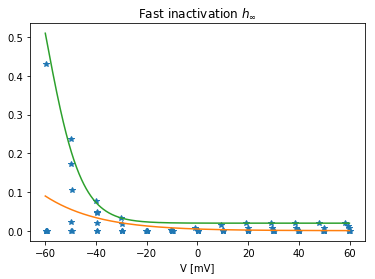

In [28]:
def sigmoid_min(p, v):
    return p[2] + (1-p[2])/(1+np.exp((p[0]-v)/p[1]))
fit_hf = scipy.optimize.least_squares(lambda p, x, y: sigmoid_min(p,x) - y, [-48., -5., .02], args = (V, hf))
plt.plot(V, hf, '*')
plt.plot(Vprobe, sigmoid_min(fit_hf.x, Vprobe))
plt.title(r'Fast inactivation $h_\infty$')
plt.xlabel('V [mV]')
print 'V_half = ', fit_hf.x[0]
print 'V_slope = ', fit_hf.x[1]
print 'noninact = ', fit_hf.x[2]

hf_p0 = [-60.,-7.,.02]
plt.plot(Vprobe, sigmoid_min(hf_p0, Vprobe));

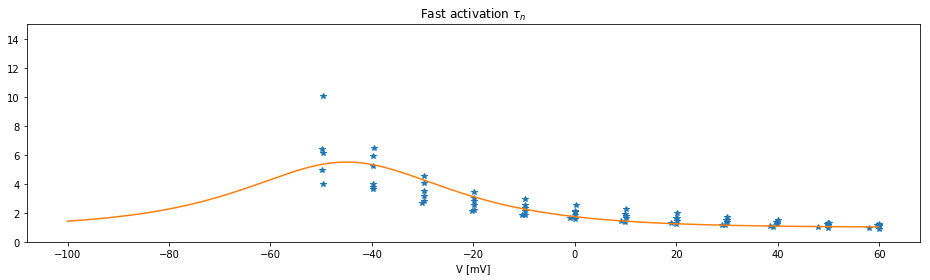

In [29]:
taunf_p0 = [1, 9., 45., 18., -18.]
def tau_model(p, V):
#   tau_min + tau_max/(np.exp((tau_off+V)/tau_slope1) + np.exp((tau_off+V)/tau_slope2))
    return p[0] + p[1]/(np.exp((p[2]+V)/p[3]) + np.exp((p[2]+V)/p[4]))

Vprobe = np.arange(-100,60,0.1)

plt.figure(figsize=(16,4))
plt.plot(V, tnf, '*')
plt.plot(Vprobe, tau_model(taunf_p0, Vprobe))

plt.title(r'Fast activation $\tau_n$')
plt.ylim(0,15)
plt.xlabel('V [mV]');

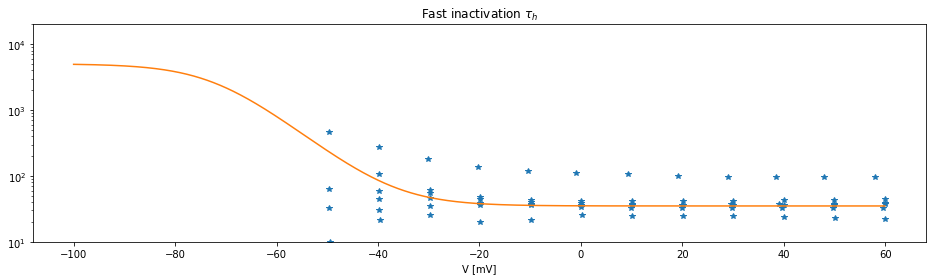

In [30]:
tauhf_p0 = [35., 5e3, 72., 7.]
def taui_model(p, V):
#     $(tauhK_min) + $(tauhK_max)/(1.0 + exp(($(tauhK_mid)-$(V))/$(tauhK_slope)))
    return p[0] + p[1]/(1. + np.exp((p[2]+V)/p[3]))

plt.figure(figsize=(16,4))
plt.semilogy(V, thf, '*')
plt.semilogy(Vprobe, taui_model(tauhf_p0, Vprobe))

plt.title(r'Fast inactivation $\tau_h$')
plt.ylim(1e1, 2e4)
plt.xlabel('V [mV]');

I don't have any data of my own for recovery from inactivation, but the few data points gleaned from the Japanese papers help, for what they're worth.
Now for the money shot: How do these values match the tail currents?

In [31]:
def state_at(t, V, state):
    '''Calculates the state (n,h) after @a t ms of holding at @a V mV from an initial @a state'''
    
    nsinf = sigmoid(ns_p0, V)
    tauns = tau_model(tauns_p0, V)
    ns = nsinf - (nsinf-state[0]) * np.exp(-t/tauns)

    hsinf = sigmoid_min(hs_p0, V)
    tauhs = taui_model(tauhs_p0, V)
    hs = hsinf - (hsinf-state[1]) * np.exp(-t/tauhs)
    
    nfinf = sigmoid(nf_p0, V)
    taunf = tau_model(taunf_p0, V)
    nf = nsinf - (nfinf-state[2]) * np.exp(-t/taunf)

    hfinf = sigmoid_min(hf_p0, V)
    tauhf = taui_model(tauhf_p0, V)
    hf = hfinf - (hfinf-state[3]) * np.exp(-t/tauhf)
    
    return (ns, hs, nf, hf)

def HH_state0(t, V, params, state0):
    state = state_at(t, V, state0)
    return (V - params['E_K']) * (params['gA_slow'] * state[0]**4 * state[1]
                                  + params['gA_fast'] * state[2]**4 * state[3])

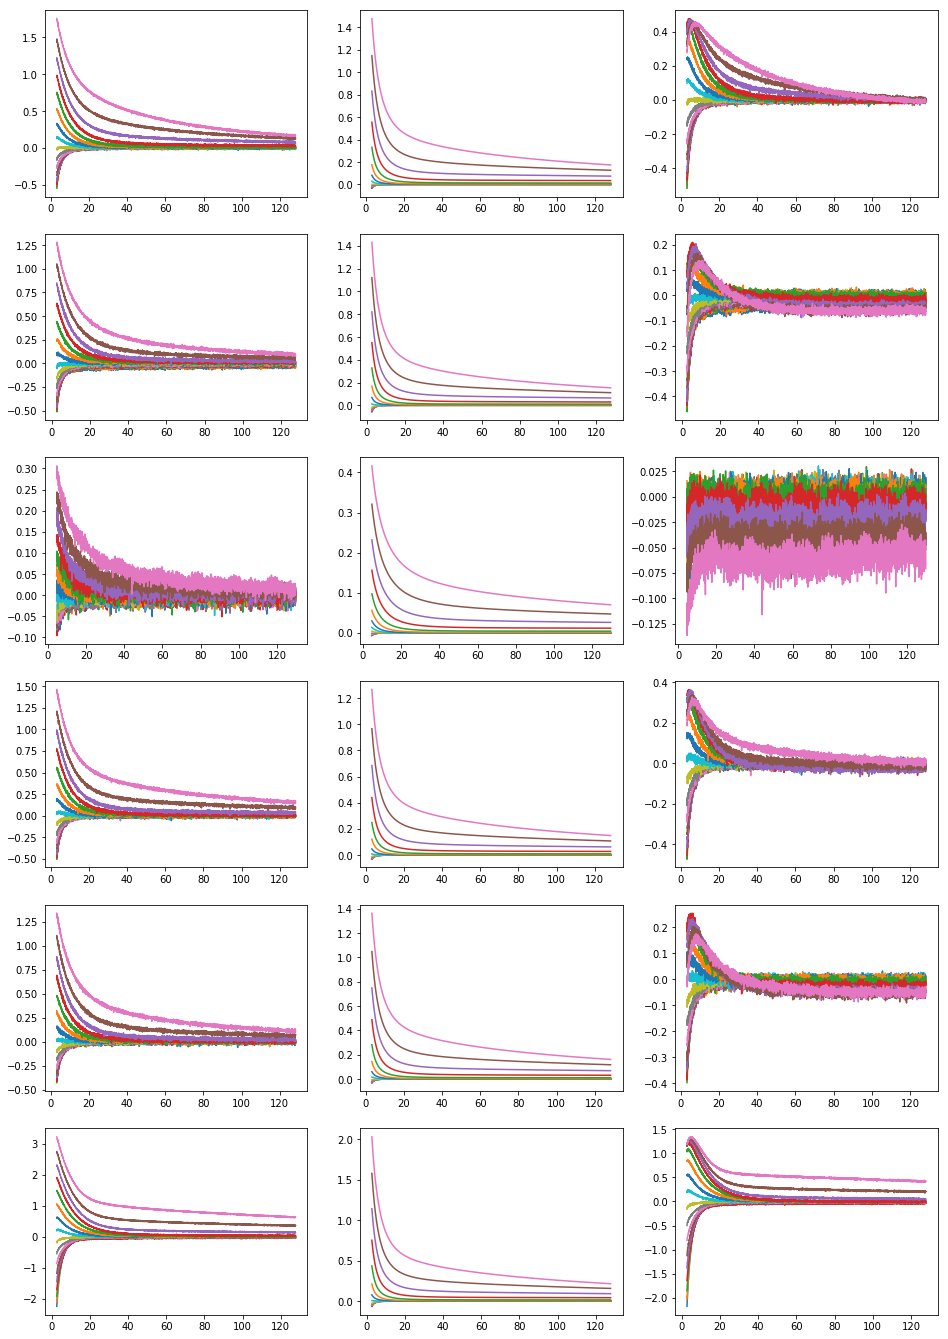

In [32]:
plt.figure(figsize=(16,4*len(ana)))
dur = 5000

tailV = [[0 for x in range(len(ana[0].rec2.current))] for y in range(len(ana))]

for j,a in enumerate(ana):
    t0 = a.rec2.tail_cut
    t = np.arange(t0 - Kv14.rec2_limits[0], t0+dur - Kv14.rec2_limits[0]) * Kv14.tres
    
    for i, current, voltage, tail_baseline in zip(range(len(a.rec2.current)),
                                                  a.rec2.current,
                                                  a.rec2.voltage,
                                                  a.rec2.tail_baseline):
        state_after_prepulse = state_at(Kv14.tres*(Kv14.rec2_limits[0]-Kv14.rec2_prepulse),
                                        np.median(voltage[Kv14.rec2_prepulse:Kv14.rec2_limits[0]]),
                                        (0,1,0,1))
        
        medV = np.median(voltage[t0:t0+dur])
        model_current = HH_state0(t, medV, a.params, state_after_prepulse)
        exp_current = current[t0:t0+dur] - tail_baseline
        
        tailV[j][i] = medV

        plt.subplot(len(ana),3,3*j+1)
        plt.plot(t, exp_current)
        
        plt.subplot(len(ana),3,3*j+2)
        plt.plot(t, model_current)
        
        plt.subplot(len(ana),3,3*j+3)
        plt.plot(t, exp_current-model_current)

Whoops, that's a bunch of taus out of whack. Let's fit them some...

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in power


0.8516635791206144


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in power
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


3.391051956374677
1.5909282568078023
0.868921314314355
2.4683826643392575
8.159675127723617

2.8884371497800543


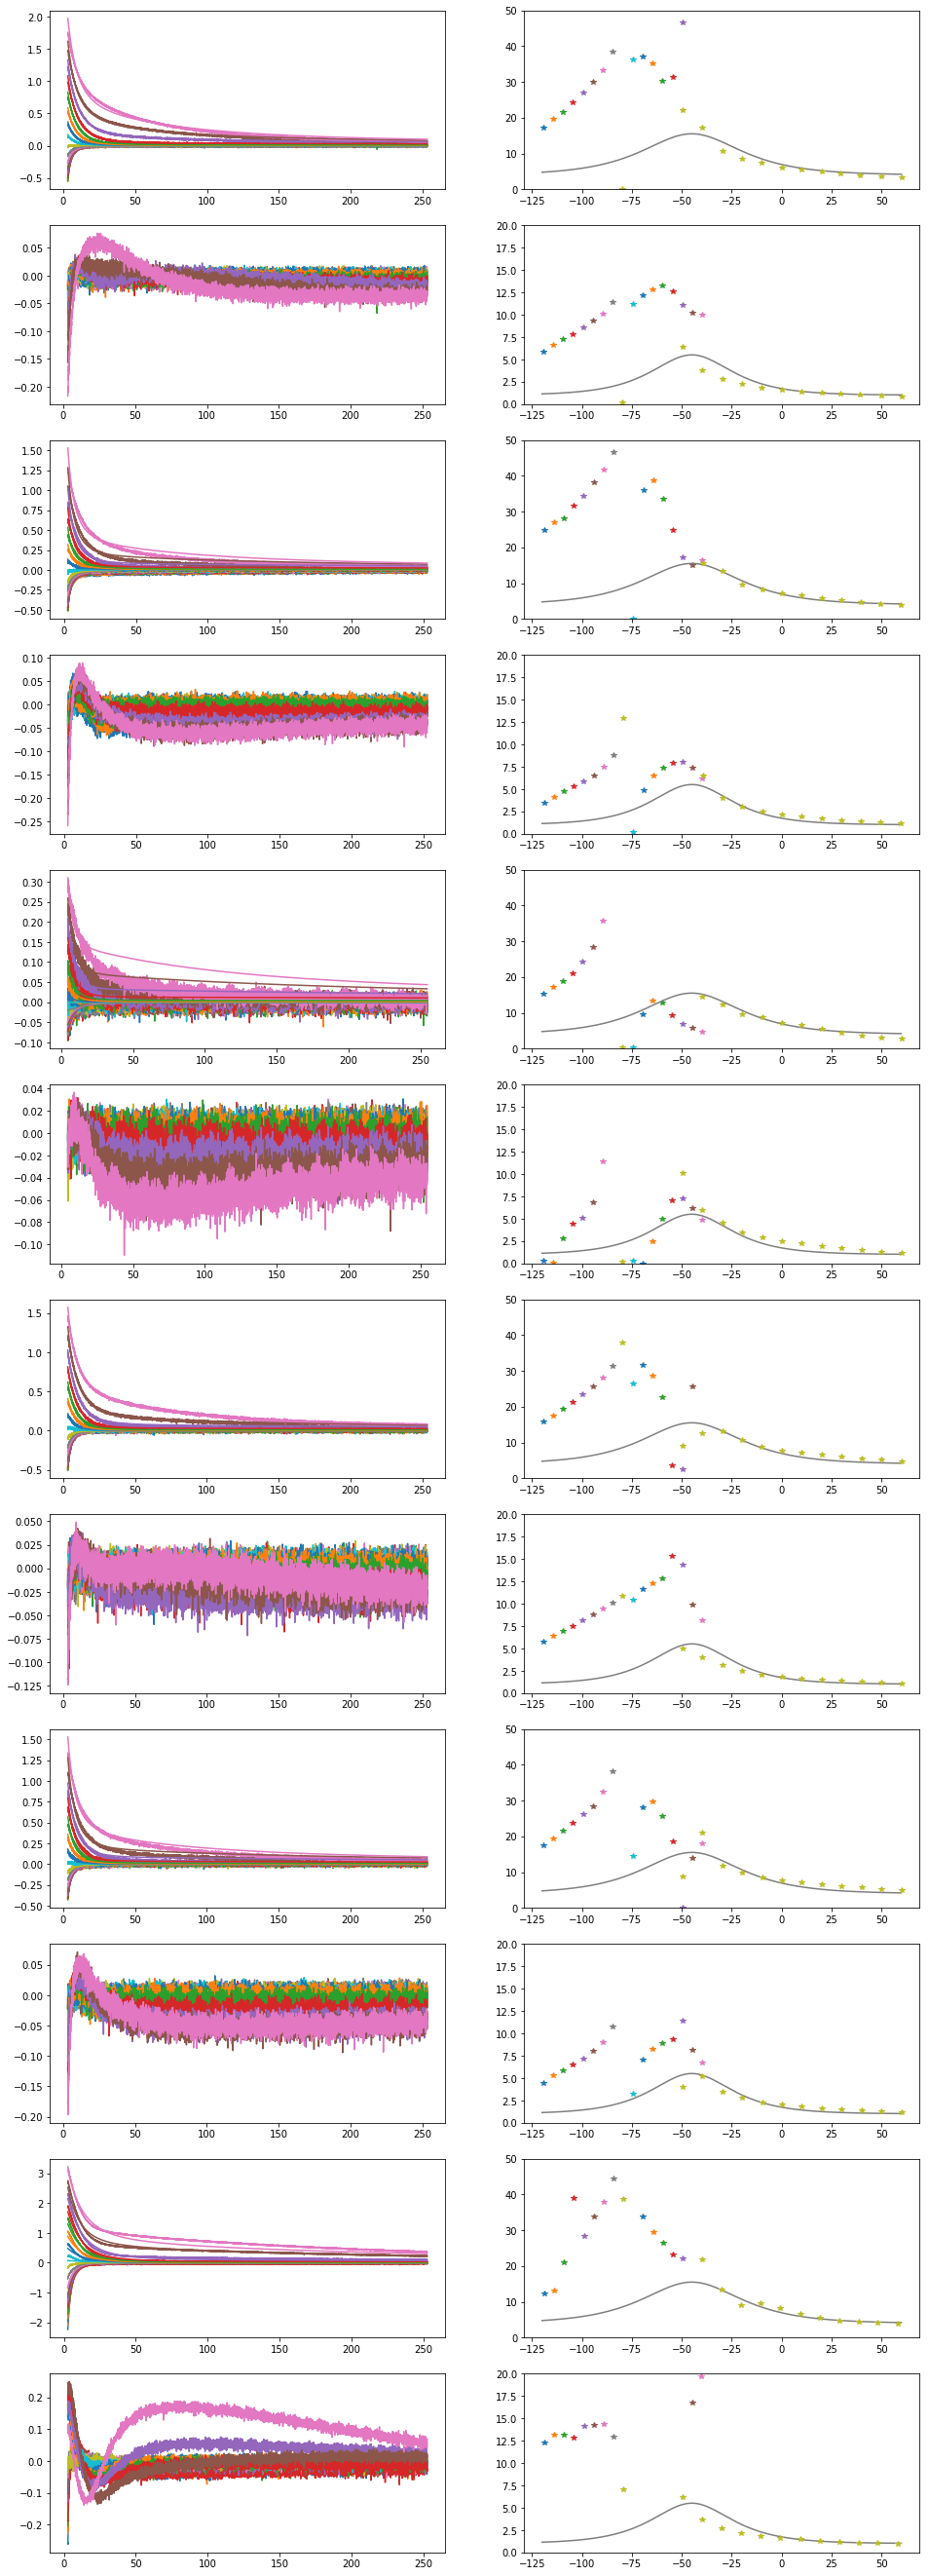

In [33]:
plt.figure(figsize=(16,8*len(ana)))
dur = 10000

def tau_guess(V):
    tauns = tau_model(tauns_p0, V)
    taunf = tau_model(taunf_p0, V)
    return [tauns, taunf]
    
def state_fixedtau(t, V, state, tau):
    nsinf = sigmoid(ns_p0, V)
    ns = nsinf - (nsinf-state[0]) * np.exp(-t/tau[0])

    hsinf = sigmoid_min(hs_p0, V)
    tauhs = taui_model(tauhs_p0, V)
    hs = hsinf - (hsinf-state[1]) * np.exp(-t/tauhs)
    
    nfinf = sigmoid(nf_p0, V)
    nf = nfinf - (nfinf-state[2]) * np.exp(-t/tau[1])

    hfinf = sigmoid_min(hf_p0, V)
    tauhf = taui_model(tauhf_p0, V)
    hf = hfinf - (hfinf-state[3]) * np.exp(-t/tauhf)
    
    return (ns, hs, nf, hf)

def HH_state0_tau(t, V, params, state0, tau):
    state = state_fixedtau(t, V, state0, tau)
    return (V - params['E_K']) * (params['gA_slow'] * state[0]**4 * state[1]
                                  + params['gA_fast'] * state[2]**4 * state[3])

taufits_ts = [[0 for x in range(len(ana[0].rec2.current))] for y in range(len(ana))]
taufits_tf = [[0 for x in range(len(ana[0].rec2.current))] for y in range(len(ana))]

mean_cost = 0.
for j,a in enumerate(ana):
    t0 = a.rec2.tail_cut
    t = np.arange(t0 - Kv14.rec2_limits[0], t0+dur - Kv14.rec2_limits[0]) * Kv14.tres
    sum_cost = 0.
    
    for current, tail_baseline in zip(a.rec2.current, a.rec2.tail_baseline):
        plt.subplot(2*len(ana),2,4*j+1)
        plt.plot(t, current[t0:t0+dur] - tail_baseline)
    plt.gca().set_prop_cycle(None)
    
    for i, current, voltage, tail_baseline in zip(range(len(a.rec2.current)),
                                                  a.rec2.current,
                                                  a.rec2.voltage,
                                                  a.rec2.tail_baseline):
        state_after_prepulse = state_at(Kv14.tres*(Kv14.rec2_limits[0]-Kv14.rec2_prepulse),
                                        np.median(voltage[Kv14.rec2_prepulse:Kv14.rec2_limits[0]]),
                                        (0,1,0,1))
        
        medV = tailV[j][i]
        exp_current = current[t0:t0+dur] - tail_baseline
        
        fit = scipy.optimize.least_squares(lambda p:
                   exp_current - HH_state0_tau(t, medV, a.params, state_after_prepulse, p),
                                           tau_guess(medV))
        sum_cost += fit.cost
        
        plt.subplot(2*len(ana),2,4*j+1)
        plt.plot(t, HH_state0_tau(t, medV, a.params, state_after_prepulse, fit.x))
        
        plt.subplot(2*len(ana),2,4*j+3)
        plt.plot(t, exp_current - HH_state0_tau(t, medV, a.params, state_after_prepulse, fit.x))
    
        plt.subplot(2*len(ana),2,4*j+2)
        plt.plot(medV, fit.x[0], '*')
    
        plt.subplot(2*len(ana),2,4*j+4)
        plt.plot(medV, fit.x[1], '*')
        
        taufits_ts[j][i] = fit.x[0]
        taufits_tf[j][i] = fit.x[1]
    
    Vprobe = np.arange(-120, 60, 0.1)
    tauprobe = tau_guess(Vprobe)
    
    ret, V_ = zip(*allfits_ext[j])
    params = [r.x for r in ret]
    V_ += a.params['E_K']
    tns_ = [el[1] * Kv14.tres for el in params]
    tnf_ = [el[5] * Kv14.tres for el in params]
    
    plt.subplot(2*len(ana),2,4*j+2)
    plt.plot(Vprobe, tauprobe[0])
    plt.plot(V_, tns_, '*')
    plt.ylim(0,50)
    
    plt.subplot(2*len(ana),2,4*j+4)
    plt.plot(Vprobe, tauprobe[1])
    plt.plot(V_, tnf_, '*')
    plt.ylim(0,20)
    
    cost = sum_cost/len(a.rec2.current)
    mean_cost += cost
    print cost
print
print mean_cost/len(ana)

Looks like tau isn't a symmetrical bump here. Let's fix this!

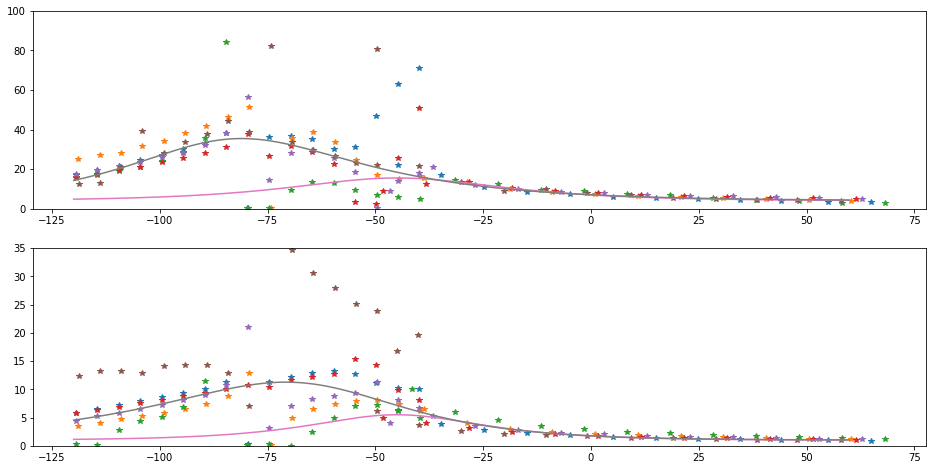

In [34]:
plt.figure(figsize=(16,8))

for taus, tauf, V, fext in zip(taufits_ts, taufits_tf, tailV, allfits_ext):
    ret, V_ = zip(*fext)
    params = [r.x for r in ret]
    V_ += a.params['E_K']
    tns_ = [el[1] * Kv14.tres for el in params]
    tnf_ = [el[5] * Kv14.tres for el in params]
    
    V = np.concatenate((V,V_))
    
    plt.subplot(2,1,1)
    plt.plot(V, np.concatenate((taus, tns_)), '*')
    
    plt.subplot(2,1,2)
    plt.plot(V, np.concatenate((tauf, tnf_)), '*')

Vprobe = np.arange(-120,60,0.1)
tauprobe = tau_guess(Vprobe)

tauns_p1 = [4, 62., 85., 28., -20.]
taunf_p1 = [1, 20., 65., 20., -32.]

plt.subplot(2,1,1)
plt.plot(Vprobe, tauprobe[0])
plt.plot(Vprobe, tau_model(tauns_p1, Vprobe))
plt.ylim(0, 100)

plt.subplot(2,1,2)
plt.plot(Vprobe, tauprobe[1])
plt.plot(Vprobe, tau_model(taunf_p1, Vprobe))
plt.ylim(0, 35);

That looks better, let's see the residual now!

In [35]:
def state_at_1(t, V, state):
    '''Calculates the state (n,h) after @a t ms of holding at @a V mV from an initial @a state'''
    
    nsinf = sigmoid(ns_p0, V)
    tauns = tau_model(tauns_p1, V)
    ns = nsinf - (nsinf-state[0]) * np.exp(-t/tauns)

    hsinf = sigmoid_min(hs_p0, V)
    tauhs = taui_model(tauhs_p0, V)
    hs = hsinf - (hsinf-state[1]) * np.exp(-t/tauhs)
    
    nfinf = sigmoid(nf_p0, V)
    taunf = tau_model(taunf_p1, V)
    nf = nfinf - (nfinf-state[2]) * np.exp(-t/taunf)

    hfinf = sigmoid_min(hf_p0, V)
    tauhf = taui_model(tauhf_p0, V)
    hf = hfinf - (hfinf-state[3]) * np.exp(-t/tauhf)
    
    return (ns, hs, nf, hf)

def HH_state0_1(t, V, params, state0):
    state = state_at_1(t, V, state0)
    return (V - params['E_K']) * (params['gA_slow'] * state[0]**4 * state[1]
                                  + params['gA_fast'] * state[2]**4 * state[3])

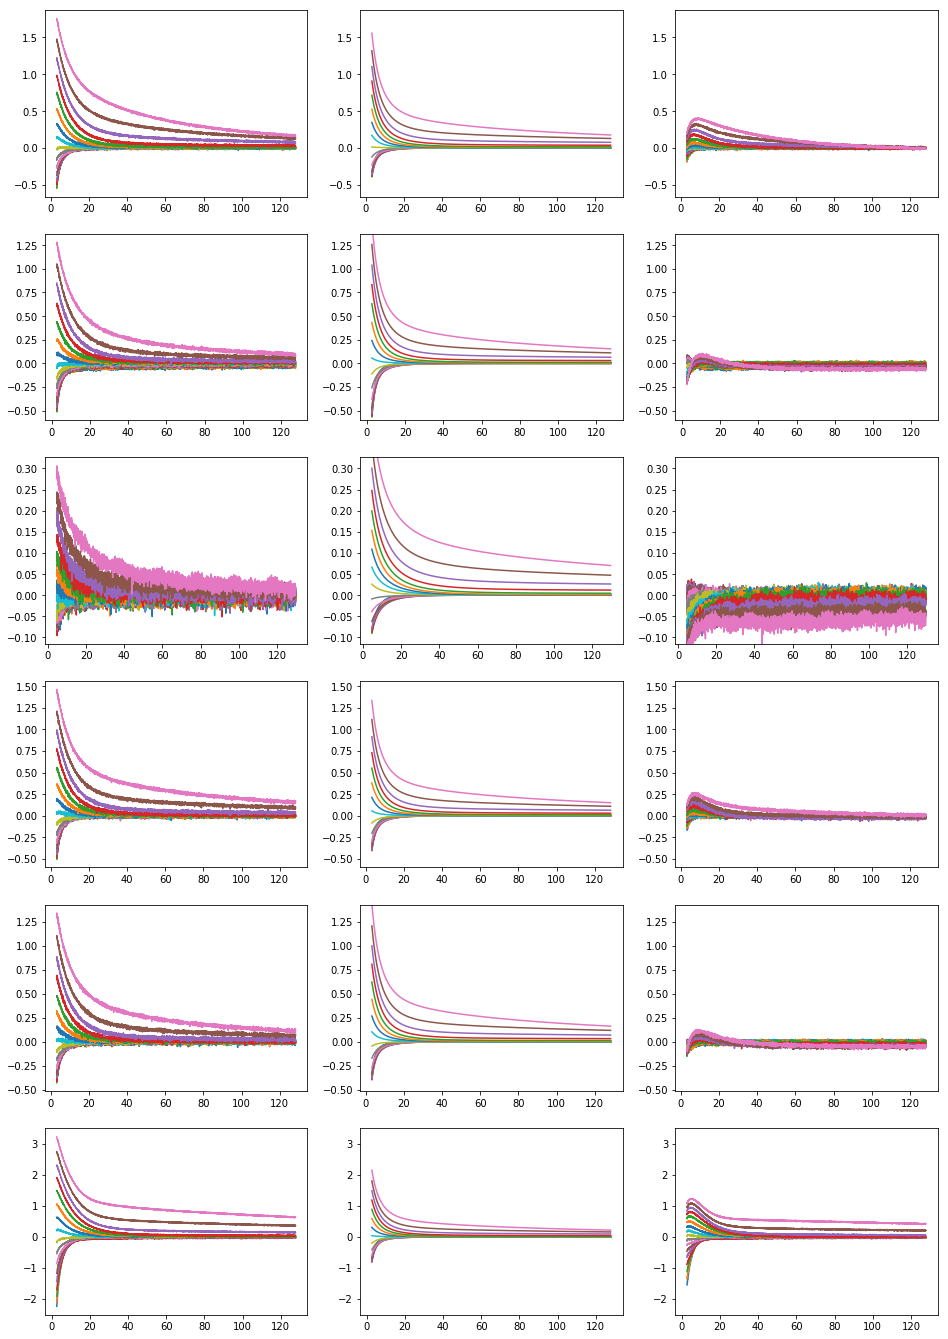

In [36]:
plt.figure(figsize=(16,4*len(ana)))
dur = 5000

tailV = [[0 for x in range(len(ana[0].rec2.current))] for y in range(len(ana))]

for j,a in enumerate(ana):
    t0 = a.rec2.tail_cut
    t = np.arange(t0 - Kv14.rec2_limits[0], t0+dur - Kv14.rec2_limits[0]) * Kv14.tres
    
    for i, current, voltage, tail_baseline in zip(range(len(a.rec2.current)),
                                                  a.rec2.current,
                                                  a.rec2.voltage,
                                                  a.rec2.tail_baseline):
        state_after_prepulse = state_at_1(Kv14.tres*(Kv14.rec2_limits[0]-Kv14.rec2_prepulse),
                                        np.median(voltage[Kv14.rec2_prepulse:Kv14.rec2_limits[0]]),
                                        (0,1,0,1))
        
        medV = np.median(voltage[t0:t0+dur])
        model_current = HH_state0_1(t, medV, a.params, state_after_prepulse)
        exp_current = current[t0:t0+dur] - tail_baseline
        
        tailV[j][i] = medV

        plt.subplot(len(ana),3,3*j+1)
        plt.plot(t, exp_current)
        
        plt.subplot(len(ana),3,3*j+2)
        plt.plot(t, model_current)
        
        plt.subplot(len(ana),3,3*j+3)
        plt.plot(t, exp_current-model_current)

    plt.subplot(len(ana),3,3*j+1)
    limExp = plt.ylim()
    plt.subplot(len(ana),3,3*j+2)
    plt.ylim(limExp)
    plt.subplot(len(ana),3,3*j+3)
    plt.ylim(limExp)

Not perfect, but pretty much good enough, as far as I'm concerned.

3.343765988736191
1.750395004183476
0.48160856697982124
1.6919748771667982
1.4672344275857112
24.186953412557653

5.486988712868275


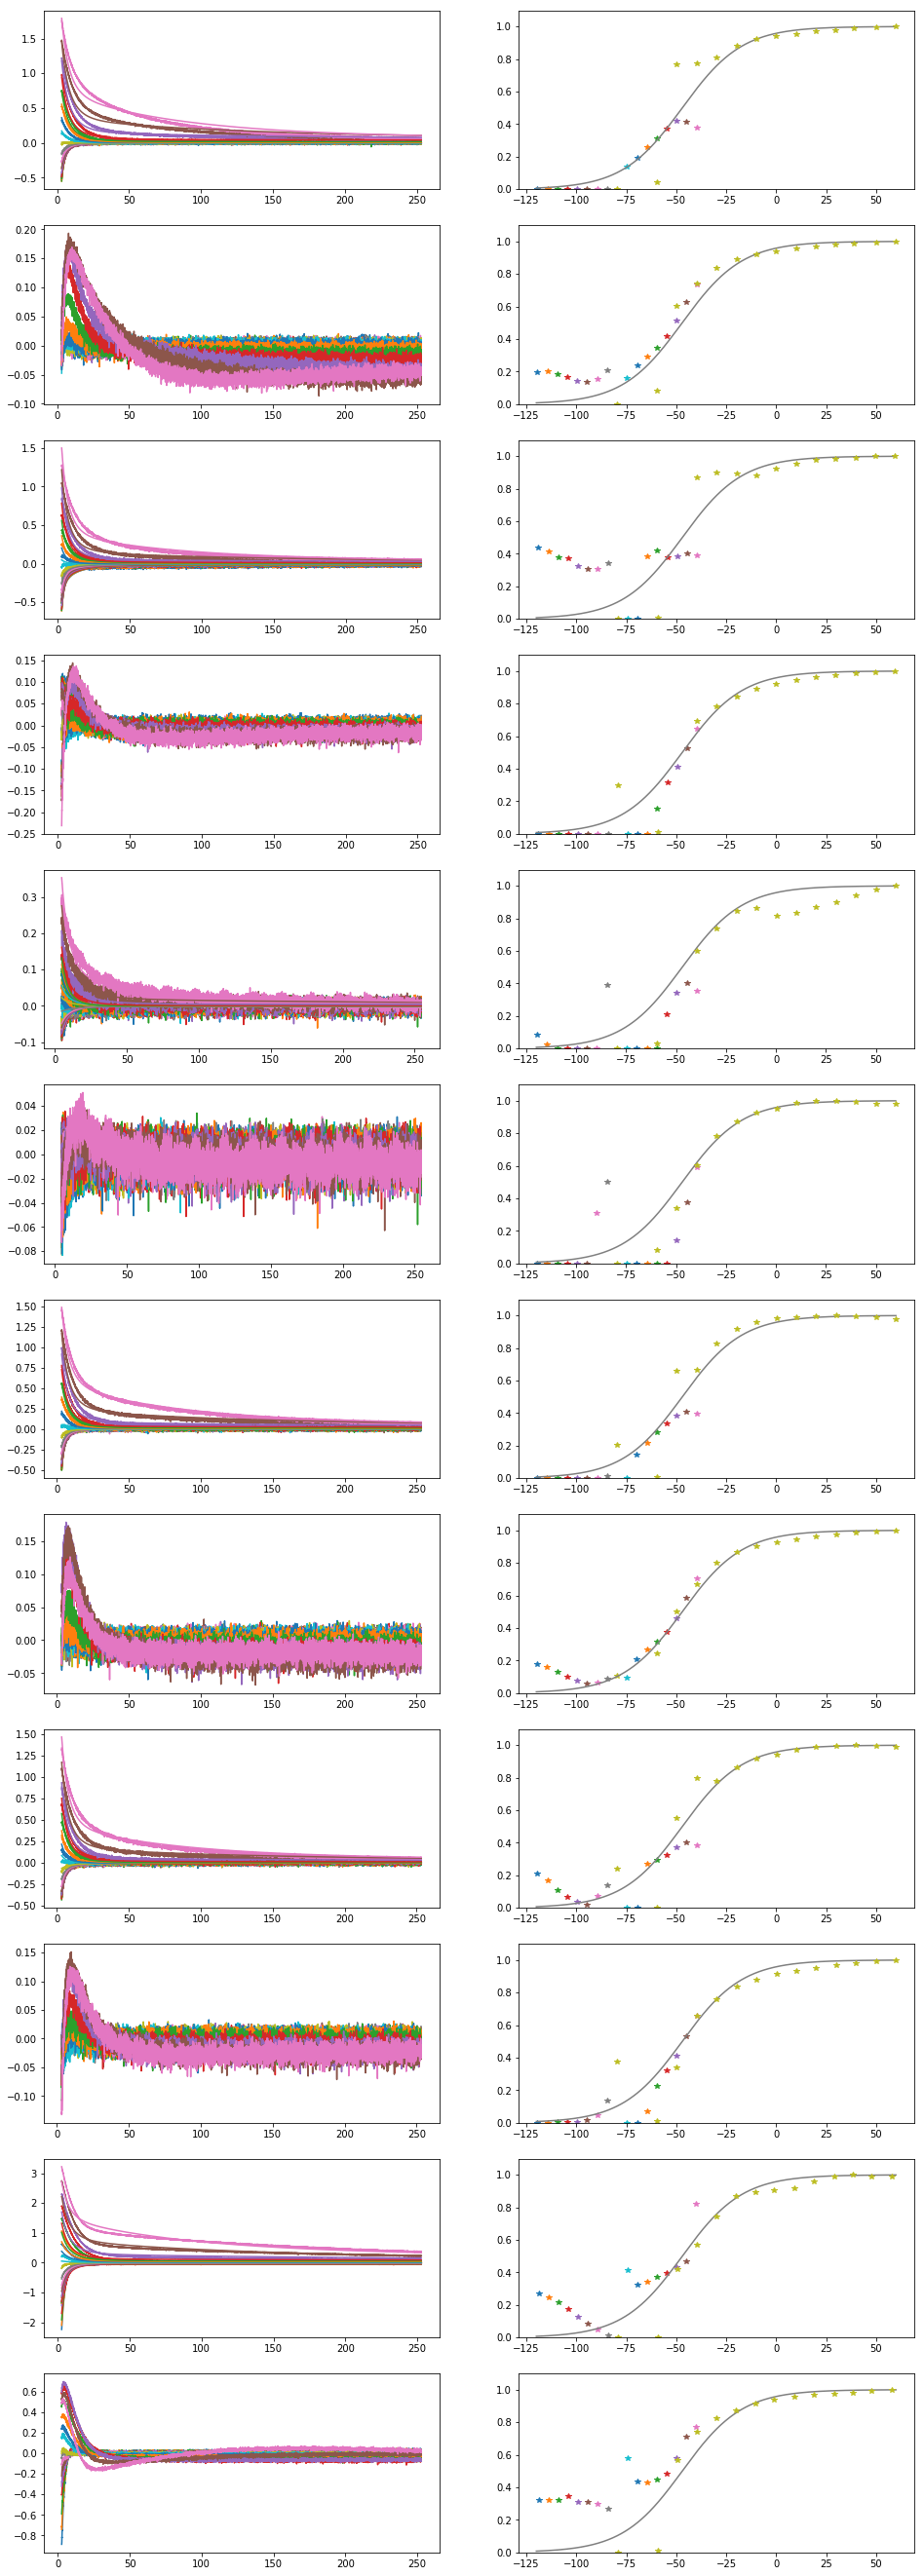

In [37]:
plt.figure(figsize=(16,8*len(ana)))
dur = 10000

def ninf_guess(V):
    nsinf = sigmoid(ns_p0, V)
    nfinf = sigmoid(nf_p0, V)
    return [nsinf, nfinf]
    
def state_fixedninf(t, V, state, ninf):
#     nsinf = sigmoid(ns_p0, V)
    nsinf = ninf[0]
    tauns = tau_model(tauns_p1, V)
    ns = nsinf - (nsinf-state[0]) * np.exp(-t/tauns)

    hsinf = sigmoid_min(hs_p0, V)
    tauhs = taui_model(tauhs_p0, V)
    hs = hsinf - (hsinf-state[1]) * np.exp(-t/tauhs)
    
#     nfinf = sigmoid(nf_p0, V)
    nfinf = ninf[1]
    taunf = tau_model(taunf_p1, V)
    nf = nfinf - (nfinf-state[2]) * np.exp(-t/taunf)

    hfinf = sigmoid_min(hf_p0, V)
    tauhf = taui_model(tauhf_p0, V)
    hf = hfinf - (hfinf-state[3]) * np.exp(-t/tauhf)
    
    return (ns, hs, nf, hf)

def HH_state0_ninf(t, V, params, state0, ninf):
    state = state_fixedninf(t, V, state0, ninf)
    return (V - params['E_K']) * (params['gA_slow'] * state[0]**4 * state[1]
                                  + params['gA_fast'] * state[2]**4 * state[3])

ninffits_ns = [[0 for x in range(len(ana[0].rec2.current))] for y in range(len(ana))]
ninffits_nf = [[0 for x in range(len(ana[0].rec2.current))] for y in range(len(ana))]

mean_cost = 0.
for j,a in enumerate(ana):
    t0 = a.rec2.tail_cut
    t = np.arange(t0 - Kv14.rec2_limits[0], t0+dur - Kv14.rec2_limits[0]) * Kv14.tres
    sum_cost = 0.
    
    for current, tail_baseline in zip(a.rec2.current, a.rec2.tail_baseline):
        plt.subplot(2*len(ana),2,4*j+1)
        plt.plot(t, current[t0:t0+dur] - tail_baseline)
    plt.gca().set_prop_cycle(None)
    
    for i, current, voltage, tail_baseline in zip(range(len(a.rec2.current)),
                                                  a.rec2.current,
                                                  a.rec2.voltage,
                                                  a.rec2.tail_baseline):
        state_after_prepulse = state_at_1(Kv14.tres*(Kv14.rec2_limits[0]-Kv14.rec2_prepulse),
                                        np.median(voltage[Kv14.rec2_prepulse:Kv14.rec2_limits[0]]),
                                        (0,1,0,1))
        
        medV = tailV[j][i]
        exp_current = current[t0:t0+dur] - tail_baseline
        
        fit = scipy.optimize.least_squares(lambda p:
                   exp_current - HH_state0_ninf(t, medV, a.params, state_after_prepulse, p),
                                           ninf_guess(medV),
                                          bounds = ([0,0],[1,1]))
        sum_cost += fit.cost
        
        plt.subplot(2*len(ana),2,4*j+1)
        plt.plot(t, HH_state0_ninf(t, medV, a.params, state_after_prepulse, fit.x))
        
        plt.subplot(2*len(ana),2,4*j+3)
        plt.plot(t, exp_current - HH_state0_ninf(t, medV, a.params, state_after_prepulse, fit.x))
    
        plt.subplot(2*len(ana),2,4*j+2)
        plt.plot(medV, fit.x[0], '*')
    
        plt.subplot(2*len(ana),2,4*j+4)
        plt.plot(medV, fit.x[1], '*')
        
        ninffits_ns[j][i] = fit.x[0]
        ninffits_nf[j][i] = fit.x[1]
    
    Vprobe = np.arange(-120, 60, 0.1)
    ninfprobe = ninf_guess(Vprobe)
    
    ret, V_ = zip(*allfits_ext[j])
    params = [r.x for r in ret]
    V_ += a.params['E_K']
    ns_ = [(el[0] / a.params['gA_slow'])**0.25 for el in params]
    nf_ = [(el[4] / a.params['gA_fast'])**0.25 for el in params]
    
    plt.subplot(2*len(ana),2,4*j+2)
    plt.plot(Vprobe, ninfprobe[0])
    plt.plot(V_, ns_, '*')
    plt.ylim(0,1.1)
    
    plt.subplot(2*len(ana),2,4*j+4)
    plt.plot(Vprobe, ninfprobe[1])
    plt.plot(V_, nf_, '*')
    plt.ylim(0,1.1)
    
    cost = sum_cost/len(a.rec2.current)
    mean_cost += cost
    print cost
print
print mean_cost/len(ana)